In [1]:
import sys
import numpy as np
sys.path.append("..")
from IPython.display import SVG
import keras
from keras.utils.vis_utils import model_to_dot
from models import autoencoderV8
from utils.data_preprocessing import encode_sequences, MinMaxScaler3D, shuffle_array
from utils.parsers import parse_bulkiness, parse_hydrophobicity, parse_csv, load_kabat, aa_order, aa3_aa1
from utils.defines import VL_LENGTH, VH_LENGTH
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.
W0423 10:33:39.245657 139826309584704 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:360: The name name_scope is deprecated. Please use compat.v1.name_scope instead.



In [2]:
class AminoAcidEncoder:
    def __init__(self, max_length, copy=True):
        """
        3D matrix scaling for RNN preparation with mask
        """
        self.copy = copy
        self.aa_order = list(map(lambda x: aa3_aa1[x], aa_order))
        self.max_length = max_length

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        result = np.zeros((len(X), self.max_length))
        for i in range(len(X)):
            for j in range(len(X[i])):
                if X[i][j] in self.aa_order:
                    result[i, j] = self.aa_order.index(X[i][j]) + 1
                else:
                    result[i, j] = len(self.aa_order)
        return result

    def inverse_transform(self, X, y=None):
        result = list()
        for i in range(X.shape[0]):
            result_i=list()
            for j in range(self.max_length):
                idx = np.where(X[i,j]==1)[0]
                if idx.size != 0:
                    idx = int(idx)
                    if idx < len(self.aa_order):
                        result_i.append(self.aa_order[idx])
                    else:
                        result_i.append('')
            print(i, ''.join(result_i))
            result.append(''.join(result_i))
        return result

In [3]:
VL_sequences, VH_sequences, names_mask, animals_mask = \
    parse_csv(VH_LENGTH, VL_LENGTH,
              "../data/abysis_data_201801/abysis_data/emblig-20180125-7578.csv",
              "../data/abysis_data_201801/abysis_data/kabat-20180117-10288.csv")

VH_encoded = AminoAcidEncoder(max_length=VH_LENGTH).transform(VH_sequences)
VL_encoded = AminoAcidEncoder(max_length=VL_LENGTH).transform(VL_sequences)

VH_encoded_shuffled, VL_encoded_shuffled = shuffle_array(VH_encoded, VL_encoded)

In [4]:
encoder, autoencoder, sess = autoencoderV8(21, latent_dim=50)

W0423 10:33:46.046442 139826309584704 deprecation_wrapper.py:76] From ../models/RNN_autoencoder8.py:24: The name ConfigProto is deprecated. Please use compat.v1.ConfigProto instead.

W0423 10:33:46.051792 139826309584704 deprecation_wrapper.py:76] From ../models/RNN_autoencoder8.py:25: The name Session is deprecated. Please use compat.v1.Session instead.

W0423 10:33:46.185954 139826309584704 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name placeholder is deprecated. Please use compat.v1.placeholder instead.

W0423 10:33:46.191023 139826309584704 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name random_uniform is deprecated. Please use random.uniform instead.

W0423 10:33:46.201063 139826309584704 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1228: The name 

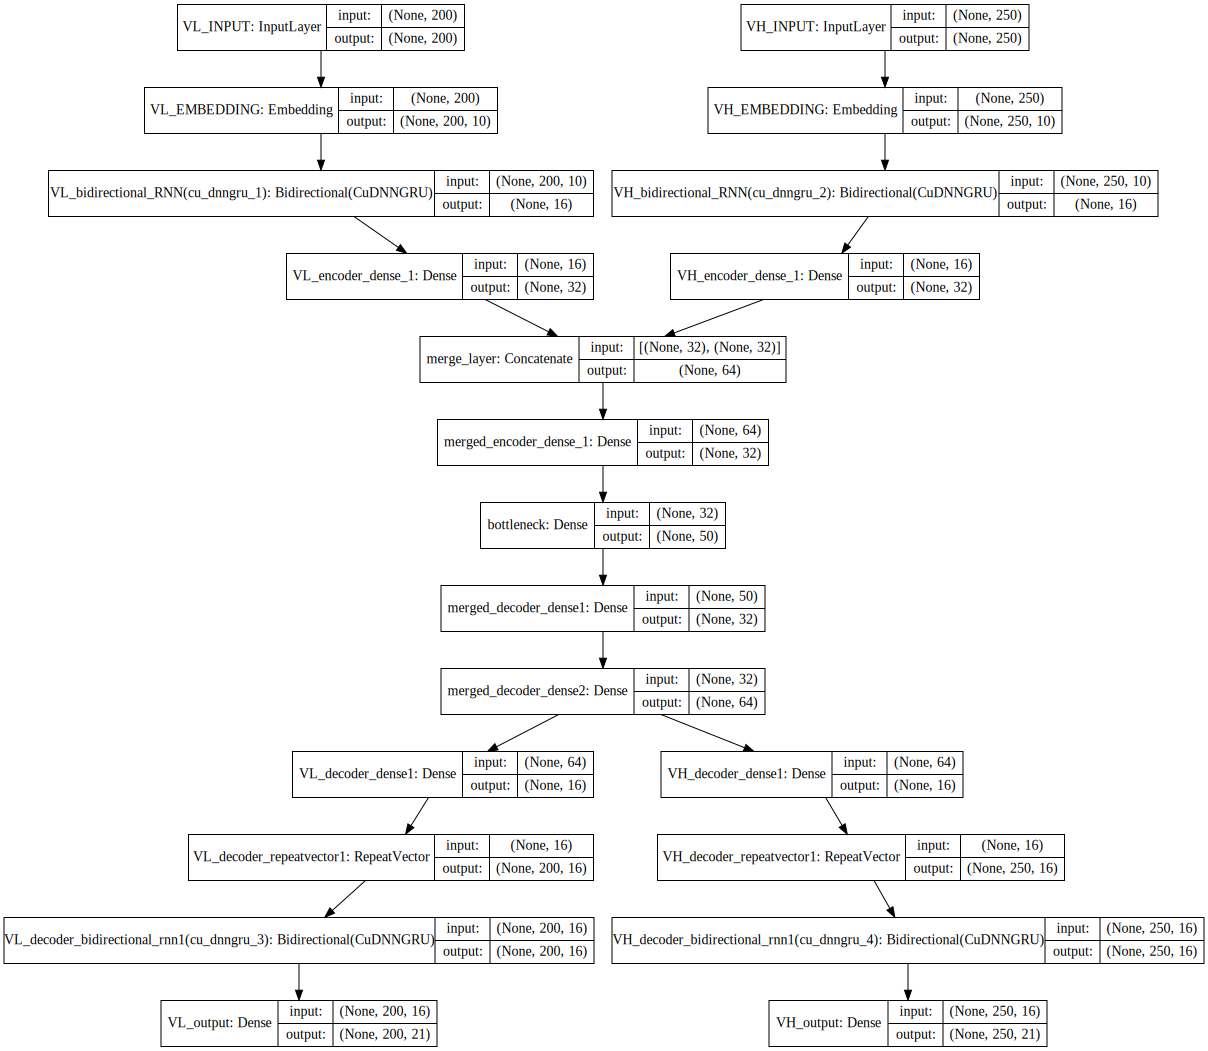

In [5]:
SVG(model_to_dot(autoencoder, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
NAME= 'autoencoderV8_raw_noannealing'
RUN = 'run1'

weight_path = '../model_weights/{}/{}/{}.hdf5'.format(NAME,RUN,NAME)
log_path = '../logs/{}/{}'.format(NAME, RUN)

In [7]:
if not os.path.exists('../model_weights/{}/{}/'.format(NAME,RUN)):
    if not os.path.exists('../model_weights/{}'.format(NAME)):
        os.mkdir('../model_weights/{}'.format(NAME))
    os.mkdir('../model_weights/{}/{}'.format(NAME,RUN))

In [8]:
from keras import backend as K

In [9]:
VL_encoded_shuffled_ohe = np.eye(21)[VL_encoded_shuffled.astype('int32')]
VH_encoded_shuffled_ohe = np.eye(21)[VH_encoded_shuffled.astype('int32')]

In [10]:
VL_encoded_shuffled_ohe.shape

(5180, 200, 21)

In [11]:
def get_loss(mask_value):

    """

    :param mask_value:
    :return:
    """

    mask_value = K.variable(mask_value, dtype=K.floatx())

    def masked_entropy(y_true, y_pred):
        # find out which timesteps in `y_true` are not the padding character
#         y_true = K.reshape(y_true, y_pred.get_shape().as_list()[:2])
        y_true = keras.layers.Reshape((y_pred.get_shape().as_list()[-2],))(y_true)
        mask = K.equal(y_true, mask_value)
        mask = 1 - K.cast(mask, K.floatx())
        mask_sum = K.sum(mask)
        l=K.tf.contrib.seq2seq.sequence_loss(targets=K.cast(y_true, 'int64'), logits=y_pred, weights=mask,
                                     average_across_batch=False, average_across_timesteps=False)
        return K.sum(l) / mask_sum
    return masked_entropy
    
lhs=K.placeholder((None,200))
rhs=K.placeholder((None,200,21))

func=get_loss(0)(lhs, rhs)
r=K.get_session().run(func, feed_dict={lhs: VL_encoded_shuffled[:1], rhs: VL_encoded_shuffled_ohe[:1]})

In [12]:
def acc(y_true, y_pred):
    y_true = keras.layers.Reshape((y_pred.get_shape().as_list()[-2],))(y_true)
    mask = K.equal(y_true, 0)
    mask = 1 - K.cast(mask, K.floatx())
    mask_sum = K.sum(mask)
    acc = K.cast(K.equal(K.cast(y_true, 'int64'), K.argmax(K.softmax(y_pred))), dtype=K.floatx()) * mask
    return K.sum(acc) / mask_sum

In [13]:
K.get_session().run(acc(lhs,rhs), feed_dict={lhs: VL_encoded_shuffled[:1], rhs: VL_encoded_shuffled_ohe[:1]})

1.0

In [14]:
autoencoder.compile(optimizer=keras.optimizers.Adamax(0.01), loss=get_loss(0), metrics=[acc])

In [ ]:
history = autoencoder.fit([VL_encoded_shuffled, VH_encoded_shuffled], [VL_encoded_shuffled, VH_encoded_shuffled],
                          epochs=5000, batch_size=32, validation_split=0.2,
                          callbacks=[keras.callbacks.ModelCheckpoint(weight_path, save_best_only=True),
                                     keras.callbacks.TensorBoard(log_path)])

Train on 4144 samples, validate on 1036 samples


W0423 10:33:50.005444 139826309584704 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:850: The name summary.merge_all is deprecated. Please use compat.v1.summary.merge_all instead.

W0423 10:33:50.006107 139826309584704 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:853: The name summary.FileWriter is deprecated. Please use compat.v1.summary.FileWriter instead.



Epoch 1/5000
4144/4144 [==============================] - 8s 2ms/step - loss: 5.6245 - VL_output_loss: 2.8065 - VH_output_loss: 2.8180 - VL_output_acc: 0.1442 - VH_output_acc: 0.1280 - val_loss: 5.5317 - val_VL_output_loss: 2.7704 - val_VH_output_loss: 2.7612 - val_VL_output_acc: 0.1486 - val_VH_output_acc: 0.1408
Epoch 2/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 5.4647 - VL_output_loss: 2.7431 - VH_output_loss: 2.7216 - VL_output_acc: 0.1506 - VH_output_acc: 0.1423 - val_loss: 5.3858 - val_VL_output_loss: 2.7075 - val_VH_output_loss: 2.6783 - val_VL_output_acc: 0.1616 - val_VH_output_acc: 0.1641
Epoch 3/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 5.3463 - VL_output_loss: 2.6918 - VH_output_loss: 2.6544 - VL_output_acc: 0.1585 - VH_output_acc: 0.1607 - val_loss: 5.2932 - val_VL_output_loss: 2.6728 - val_VH_output_loss: 2.6205 - val_VL_output_acc: 0.1624 - val_VH_output_acc: 0.1673
Epoch 4/5000
4144/4144 [============================

Epoch 27/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.4194 - VL_output_loss: 2.1459 - VH_output_loss: 2.2734 - VL_output_acc: 0.3253 - VH_output_acc: 0.2658 - val_loss: 4.3417 - val_VL_output_loss: 2.0934 - val_VH_output_loss: 2.2483 - val_VL_output_acc: 0.3471 - val_VH_output_acc: 0.2850
Epoch 28/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3888 - VL_output_loss: 2.1417 - VH_output_loss: 2.2471 - VL_output_acc: 0.3274 - VH_output_acc: 0.2780 - val_loss: 4.3688 - val_VL_output_loss: 2.1236 - val_VH_output_loss: 2.2452 - val_VL_output_acc: 0.3373 - val_VH_output_acc: 0.2805
Epoch 29/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3697 - VL_output_loss: 2.1214 - VH_output_loss: 2.2483 - VL_output_acc: 0.3372 - VH_output_acc: 0.2757 - val_loss: 4.3425 - val_VL_output_loss: 2.1043 - val_VH_output_loss: 2.2381 - val_VL_output_acc: 0.3388 - val_VH_output_acc: 0.2877
Epoch 30/5000
4144/4144 [========================

Epoch 53/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1385 - VL_output_loss: 1.9821 - VH_output_loss: 2.1565 - VL_output_acc: 0.3955 - VH_output_acc: 0.3102 - val_loss: 4.1922 - val_VL_output_loss: 1.9910 - val_VH_output_loss: 2.2012 - val_VL_output_acc: 0.3817 - val_VH_output_acc: 0.2842
Epoch 54/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1708 - VL_output_loss: 2.0017 - VH_output_loss: 2.1691 - VL_output_acc: 0.3877 - VH_output_acc: 0.3025 - val_loss: 4.1470 - val_VL_output_loss: 1.9701 - val_VH_output_loss: 2.1769 - val_VL_output_acc: 0.4004 - val_VH_output_acc: 0.3050
Epoch 55/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1294 - VL_output_loss: 1.9760 - VH_output_loss: 2.1535 - VL_output_acc: 0.4001 - VH_output_acc: 0.3109 - val_loss: 4.1360 - val_VL_output_loss: 1.9646 - val_VH_output_loss: 2.1714 - val_VL_output_acc: 0.3952 - val_VH_output_acc: 0.3046
Epoch 56/5000
4144/4144 [========================

Epoch 79/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0261 - VL_output_loss: 1.9116 - VH_output_loss: 2.1145 - VL_output_acc: 0.4237 - VH_output_acc: 0.3317 - val_loss: 4.0061 - val_VL_output_loss: 1.8829 - val_VH_output_loss: 2.1232 - val_VL_output_acc: 0.4359 - val_VH_output_acc: 0.3339
Epoch 80/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0065 - VL_output_loss: 1.9000 - VH_output_loss: 2.1065 - VL_output_acc: 0.4307 - VH_output_acc: 0.3365 - val_loss: 4.0088 - val_VL_output_loss: 1.8772 - val_VH_output_loss: 2.1316 - val_VL_output_acc: 0.4400 - val_VH_output_acc: 0.3262
Epoch 81/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0354 - VL_output_loss: 1.9178 - VH_output_loss: 2.1176 - VL_output_acc: 0.4195 - VH_output_acc: 0.3294 - val_loss: 4.0697 - val_VL_output_loss: 1.9523 - val_VH_output_loss: 2.1174 - val_VL_output_acc: 0.3900 - val_VH_output_acc: 0.3399
Epoch 82/5000
4144/4144 [========================

Epoch 105/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9328 - VL_output_loss: 1.8493 - VH_output_loss: 2.0835 - VL_output_acc: 0.4566 - VH_output_acc: 0.3443 - val_loss: 3.9557 - val_VL_output_loss: 1.8140 - val_VH_output_loss: 2.1417 - val_VL_output_acc: 0.4743 - val_VH_output_acc: 0.3228
Epoch 106/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9779 - VL_output_loss: 1.8856 - VH_output_loss: 2.0924 - VL_output_acc: 0.4359 - VH_output_acc: 0.3404 - val_loss: 4.0152 - val_VL_output_loss: 1.8684 - val_VH_output_loss: 2.1468 - val_VL_output_acc: 0.4416 - val_VH_output_acc: 0.3297
Epoch 107/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9907 - VL_output_loss: 1.8811 - VH_output_loss: 2.1096 - VL_output_acc: 0.4394 - VH_output_acc: 0.3391 - val_loss: 4.0196 - val_VL_output_loss: 1.8905 - val_VH_output_loss: 2.1291 - val_VL_output_acc: 0.4351 - val_VH_output_acc: 0.3438
Epoch 108/5000
4144/4144 [====================

Epoch 131/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8934 - VL_output_loss: 1.8247 - VH_output_loss: 2.0687 - VL_output_acc: 0.4660 - VH_output_acc: 0.3507 - val_loss: 3.9021 - val_VL_output_loss: 1.8132 - val_VH_output_loss: 2.0890 - val_VL_output_acc: 0.4699 - val_VH_output_acc: 0.3505
Epoch 132/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9218 - VL_output_loss: 1.8511 - VH_output_loss: 2.0707 - VL_output_acc: 0.4566 - VH_output_acc: 0.3512 - val_loss: 3.9243 - val_VL_output_loss: 1.8096 - val_VH_output_loss: 2.1147 - val_VL_output_acc: 0.4776 - val_VH_output_acc: 0.3366
Epoch 133/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9002 - VL_output_loss: 1.8579 - VH_output_loss: 2.0423 - VL_output_acc: 0.4493 - VH_output_acc: 0.3654 - val_loss: 3.8327 - val_VL_output_loss: 1.7732 - val_VH_output_loss: 2.0595 - val_VL_output_acc: 0.4904 - val_VH_output_acc: 0.3658
Epoch 134/5000
4144/4144 [====================

Epoch 157/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9252 - VL_output_loss: 1.8616 - VH_output_loss: 2.0635 - VL_output_acc: 0.4450 - VH_output_acc: 0.3575 - val_loss: 3.8852 - val_VL_output_loss: 1.7721 - val_VH_output_loss: 2.1131 - val_VL_output_acc: 0.4866 - val_VH_output_acc: 0.3453
Epoch 158/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8939 - VL_output_loss: 1.8302 - VH_output_loss: 2.0637 - VL_output_acc: 0.4592 - VH_output_acc: 0.3559 - val_loss: 3.9653 - val_VL_output_loss: 1.8849 - val_VH_output_loss: 2.0804 - val_VL_output_acc: 0.4261 - val_VH_output_acc: 0.3514
Epoch 159/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9111 - VL_output_loss: 1.8610 - VH_output_loss: 2.0501 - VL_output_acc: 0.4435 - VH_output_acc: 0.3626 - val_loss: 3.8469 - val_VL_output_loss: 1.7740 - val_VH_output_loss: 2.0730 - val_VL_output_acc: 0.4771 - val_VH_output_acc: 0.3513
Epoch 160/5000
4144/4144 [====================

Epoch 183/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8781 - VL_output_loss: 1.8237 - VH_output_loss: 2.0544 - VL_output_acc: 0.4588 - VH_output_acc: 0.3611 - val_loss: 4.0239 - val_VL_output_loss: 1.9076 - val_VH_output_loss: 2.1163 - val_VL_output_acc: 0.4161 - val_VH_output_acc: 0.3426
Epoch 184/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8068 - VL_output_loss: 1.7788 - VH_output_loss: 2.0281 - VL_output_acc: 0.4828 - VH_output_acc: 0.3764 - val_loss: 3.7742 - val_VL_output_loss: 1.7285 - val_VH_output_loss: 2.0457 - val_VL_output_acc: 0.5057 - val_VH_output_acc: 0.3819
Epoch 185/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7863 - VL_output_loss: 1.7572 - VH_output_loss: 2.0291 - VL_output_acc: 0.4916 - VH_output_acc: 0.3740 - val_loss: 3.7997 - val_VL_output_loss: 1.7439 - val_VH_output_loss: 2.0558 - val_VL_output_acc: 0.5006 - val_VH_output_acc: 0.3776
Epoch 186/5000
4144/4144 [====================

Epoch 209/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9997 - VL_output_loss: 1.9655 - VH_output_loss: 2.0342 - VL_output_acc: 0.4230 - VH_output_acc: 0.3788 - val_loss: 4.2078 - val_VL_output_loss: 1.9508 - val_VH_output_loss: 2.2570 - val_VL_output_acc: 0.4173 - val_VH_output_acc: 0.2745
Epoch 210/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9519 - VL_output_loss: 1.9173 - VH_output_loss: 2.0346 - VL_output_acc: 0.4391 - VH_output_acc: 0.3780 - val_loss: 3.9864 - val_VL_output_loss: 1.9281 - val_VH_output_loss: 2.0583 - val_VL_output_acc: 0.4246 - val_VH_output_acc: 0.3749
Epoch 211/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9952 - VL_output_loss: 1.9627 - VH_output_loss: 2.0325 - VL_output_acc: 0.4159 - VH_output_acc: 0.3788 - val_loss: 4.8143 - val_VL_output_loss: 2.7182 - val_VH_output_loss: 2.0961 - val_VL_output_acc: 0.2135 - val_VH_output_acc: 0.3580
Epoch 212/5000
4144/4144 [====================

Epoch 235/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3635 - VL_output_loss: 2.3397 - VH_output_loss: 2.0238 - VL_output_acc: 0.2664 - VH_output_acc: 0.3847 - val_loss: 4.4235 - val_VL_output_loss: 2.3467 - val_VH_output_loss: 2.0768 - val_VL_output_acc: 0.2645 - val_VH_output_acc: 0.3726
Epoch 236/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3806 - VL_output_loss: 2.3370 - VH_output_loss: 2.0435 - VL_output_acc: 0.2652 - VH_output_acc: 0.3793 - val_loss: 4.4151 - val_VL_output_loss: 2.3377 - val_VH_output_loss: 2.0774 - val_VL_output_acc: 0.2566 - val_VH_output_acc: 0.3644
Epoch 237/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3632 - VL_output_loss: 2.3357 - VH_output_loss: 2.0276 - VL_output_acc: 0.2644 - VH_output_acc: 0.3789 - val_loss: 4.3434 - val_VL_output_loss: 2.3122 - val_VH_output_loss: 2.0312 - val_VL_output_acc: 0.2645 - val_VH_output_acc: 0.3853
Epoch 238/5000
4144/4144 [====================

Epoch 261/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2880 - VL_output_loss: 2.2313 - VH_output_loss: 2.0568 - VL_output_acc: 0.2953 - VH_output_acc: 0.3673 - val_loss: 4.1961 - val_VL_output_loss: 2.1791 - val_VH_output_loss: 2.0170 - val_VL_output_acc: 0.3105 - val_VH_output_acc: 0.3946
Epoch 262/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1984 - VL_output_loss: 2.2143 - VH_output_loss: 1.9841 - VL_output_acc: 0.2975 - VH_output_acc: 0.3995 - val_loss: 4.1796 - val_VL_output_loss: 2.1863 - val_VH_output_loss: 1.9933 - val_VL_output_acc: 0.3136 - val_VH_output_acc: 0.4049
Epoch 263/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2160 - VL_output_loss: 2.2267 - VH_output_loss: 1.9894 - VL_output_acc: 0.2956 - VH_output_acc: 0.3959 - val_loss: 4.2683 - val_VL_output_loss: 2.2469 - val_VH_output_loss: 2.0215 - val_VL_output_acc: 0.2986 - val_VH_output_acc: 0.3926
Epoch 264/5000
4144/4144 [====================

Epoch 287/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1702 - VL_output_loss: 2.1518 - VH_output_loss: 2.0183 - VL_output_acc: 0.3268 - VH_output_acc: 0.3809 - val_loss: 4.1731 - val_VL_output_loss: 2.1894 - val_VH_output_loss: 1.9837 - val_VL_output_acc: 0.2950 - val_VH_output_acc: 0.4080
Epoch 288/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1114 - VL_output_loss: 2.1529 - VH_output_loss: 1.9585 - VL_output_acc: 0.3274 - VH_output_acc: 0.4103 - val_loss: 4.1357 - val_VL_output_loss: 2.1106 - val_VH_output_loss: 2.0251 - val_VL_output_acc: 0.3481 - val_VH_output_acc: 0.3843
Epoch 289/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1298 - VL_output_loss: 2.1289 - VH_output_loss: 2.0008 - VL_output_acc: 0.3348 - VH_output_acc: 0.3901 - val_loss: 4.5748 - val_VL_output_loss: 2.5314 - val_VH_output_loss: 2.0435 - val_VL_output_acc: 0.2054 - val_VH_output_acc: 0.3670
Epoch 290/5000
4144/4144 [====================

Epoch 313/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0574 - VL_output_loss: 2.1244 - VH_output_loss: 1.9330 - VL_output_acc: 0.3323 - VH_output_acc: 0.4270 - val_loss: 4.1645 - val_VL_output_loss: 2.2026 - val_VH_output_loss: 1.9619 - val_VL_output_acc: 0.2909 - val_VH_output_acc: 0.4191
Epoch 314/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0113 - VL_output_loss: 2.0731 - VH_output_loss: 1.9382 - VL_output_acc: 0.3568 - VH_output_acc: 0.4235 - val_loss: 4.0420 - val_VL_output_loss: 2.0546 - val_VH_output_loss: 1.9874 - val_VL_output_acc: 0.3576 - val_VH_output_acc: 0.4117
Epoch 315/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0234 - VL_output_loss: 2.0774 - VH_output_loss: 1.9460 - VL_output_acc: 0.3530 - VH_output_acc: 0.4184 - val_loss: 4.0047 - val_VL_output_loss: 2.0335 - val_VH_output_loss: 1.9712 - val_VL_output_acc: 0.3805 - val_VH_output_acc: 0.4193
Epoch 316/5000
4144/4144 [====================

Epoch 339/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9336 - VL_output_loss: 2.0188 - VH_output_loss: 1.9148 - VL_output_acc: 0.3804 - VH_output_acc: 0.4309 - val_loss: 4.0193 - val_VL_output_loss: 2.0879 - val_VH_output_loss: 1.9314 - val_VL_output_acc: 0.3223 - val_VH_output_acc: 0.4319
Epoch 340/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9804 - VL_output_loss: 2.0354 - VH_output_loss: 1.9450 - VL_output_acc: 0.3722 - VH_output_acc: 0.4194 - val_loss: 4.1007 - val_VL_output_loss: 2.1227 - val_VH_output_loss: 1.9780 - val_VL_output_acc: 0.3152 - val_VH_output_acc: 0.4143
Epoch 341/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0208 - VL_output_loss: 2.0699 - VH_output_loss: 1.9509 - VL_output_acc: 0.3554 - VH_output_acc: 0.4192 - val_loss: 4.2292 - val_VL_output_loss: 2.2103 - val_VH_output_loss: 2.0189 - val_VL_output_acc: 0.2890 - val_VH_output_acc: 0.4018
Epoch 342/5000
4144/4144 [====================

Epoch 365/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8464 - VL_output_loss: 1.9389 - VH_output_loss: 1.9075 - VL_output_acc: 0.4118 - VH_output_acc: 0.4334 - val_loss: 4.3965 - val_VL_output_loss: 2.4424 - val_VH_output_loss: 1.9541 - val_VL_output_acc: 0.2411 - val_VH_output_acc: 0.4312
Epoch 366/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8765 - VL_output_loss: 1.9634 - VH_output_loss: 1.9131 - VL_output_acc: 0.4035 - VH_output_acc: 0.4321 - val_loss: 3.8629 - val_VL_output_loss: 1.9168 - val_VH_output_loss: 1.9461 - val_VL_output_acc: 0.4211 - val_VH_output_acc: 0.4223
Epoch 367/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9164 - VL_output_loss: 1.9804 - VH_output_loss: 1.9360 - VL_output_acc: 0.3873 - VH_output_acc: 0.4206 - val_loss: 3.8734 - val_VL_output_loss: 1.9498 - val_VH_output_loss: 1.9236 - val_VL_output_acc: 0.3943 - val_VH_output_acc: 0.4370
Epoch 368/5000
4144/4144 [====================

Epoch 391/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7602 - VL_output_loss: 1.8838 - VH_output_loss: 1.8764 - VL_output_acc: 0.4328 - VH_output_acc: 0.4442 - val_loss: 3.7473 - val_VL_output_loss: 1.8434 - val_VH_output_loss: 1.9039 - val_VL_output_acc: 0.4682 - val_VH_output_acc: 0.4424
Epoch 392/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7455 - VL_output_loss: 1.8781 - VH_output_loss: 1.8674 - VL_output_acc: 0.4374 - VH_output_acc: 0.4494 - val_loss: 3.7971 - val_VL_output_loss: 1.8386 - val_VH_output_loss: 1.9585 - val_VL_output_acc: 0.4647 - val_VH_output_acc: 0.4156
Epoch 393/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7722 - VL_output_loss: 1.8856 - VH_output_loss: 1.8865 - VL_output_acc: 0.4328 - VH_output_acc: 0.4409 - val_loss: 3.7506 - val_VL_output_loss: 1.8423 - val_VH_output_loss: 1.9083 - val_VL_output_acc: 0.4580 - val_VH_output_acc: 0.4374
Epoch 394/5000
4144/4144 [====================

Epoch 417/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6674 - VL_output_loss: 1.8091 - VH_output_loss: 1.8583 - VL_output_acc: 0.4684 - VH_output_acc: 0.4484 - val_loss: 3.6960 - val_VL_output_loss: 1.7840 - val_VH_output_loss: 1.9120 - val_VL_output_acc: 0.4841 - val_VH_output_acc: 0.4369
Epoch 418/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7268 - VL_output_loss: 1.8721 - VH_output_loss: 1.8547 - VL_output_acc: 0.4346 - VH_output_acc: 0.4506 - val_loss: 3.6540 - val_VL_output_loss: 1.7731 - val_VH_output_loss: 1.8808 - val_VL_output_acc: 0.4892 - val_VH_output_acc: 0.4488
Epoch 419/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6544 - VL_output_loss: 1.8052 - VH_output_loss: 1.8492 - VL_output_acc: 0.4685 - VH_output_acc: 0.4516 - val_loss: 4.1864 - val_VL_output_loss: 2.3051 - val_VH_output_loss: 1.8813 - val_VL_output_acc: 0.2990 - val_VH_output_acc: 0.4470
Epoch 420/5000
4144/4144 [====================

Epoch 443/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6254 - VL_output_loss: 1.7850 - VH_output_loss: 1.8404 - VL_output_acc: 0.4751 - VH_output_acc: 0.4551 - val_loss: 3.6970 - val_VL_output_loss: 1.7975 - val_VH_output_loss: 1.8995 - val_VL_output_acc: 0.4764 - val_VH_output_acc: 0.4382
Epoch 444/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6767 - VL_output_loss: 1.8150 - VH_output_loss: 1.8617 - VL_output_acc: 0.4592 - VH_output_acc: 0.4458 - val_loss: 3.7994 - val_VL_output_loss: 1.8366 - val_VH_output_loss: 1.9628 - val_VL_output_acc: 0.4339 - val_VH_output_acc: 0.4181
Epoch 445/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7190 - VL_output_loss: 1.7836 - VH_output_loss: 1.9354 - VL_output_acc: 0.4765 - VH_output_acc: 0.4179 - val_loss: 3.7705 - val_VL_output_loss: 1.8803 - val_VH_output_loss: 1.8901 - val_VL_output_acc: 0.4145 - val_VH_output_acc: 0.4438
Epoch 446/5000
4144/4144 [====================

Epoch 469/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5813 - VL_output_loss: 1.7512 - VH_output_loss: 1.8301 - VL_output_acc: 0.4879 - VH_output_acc: 0.4596 - val_loss: 3.6215 - val_VL_output_loss: 1.7361 - val_VH_output_loss: 1.8853 - val_VL_output_acc: 0.5049 - val_VH_output_acc: 0.4466
Epoch 470/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5999 - VL_output_loss: 1.7500 - VH_output_loss: 1.8499 - VL_output_acc: 0.4889 - VH_output_acc: 0.4517 - val_loss: 3.7027 - val_VL_output_loss: 1.7966 - val_VH_output_loss: 1.9061 - val_VL_output_acc: 0.4567 - val_VH_output_acc: 0.4368
Epoch 471/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6579 - VL_output_loss: 1.7949 - VH_output_loss: 1.8629 - VL_output_acc: 0.4659 - VH_output_acc: 0.4447 - val_loss: 3.6393 - val_VL_output_loss: 1.7553 - val_VH_output_loss: 1.8841 - val_VL_output_acc: 0.4825 - val_VH_output_acc: 0.4455
Epoch 472/5000
4144/4144 [====================

Epoch 495/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6143 - VL_output_loss: 1.7532 - VH_output_loss: 1.8611 - VL_output_acc: 0.4853 - VH_output_acc: 0.4472 - val_loss: 3.6060 - val_VL_output_loss: 1.7372 - val_VH_output_loss: 1.8688 - val_VL_output_acc: 0.4946 - val_VH_output_acc: 0.4548
Epoch 496/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5640 - VL_output_loss: 1.7189 - VH_output_loss: 1.8451 - VL_output_acc: 0.5031 - VH_output_acc: 0.4526 - val_loss: 3.5202 - val_VL_output_loss: 1.6795 - val_VH_output_loss: 1.8407 - val_VL_output_acc: 0.5213 - val_VH_output_acc: 0.4657
Epoch 497/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5679 - VL_output_loss: 1.7438 - VH_output_loss: 1.8241 - VL_output_acc: 0.4910 - VH_output_acc: 0.4610 - val_loss: 3.5454 - val_VL_output_loss: 1.6947 - val_VH_output_loss: 1.8507 - val_VL_output_acc: 0.5190 - val_VH_output_acc: 0.4571
Epoch 498/5000
4144/4144 [====================

Epoch 521/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.3298 - VL_output_loss: 1.7321 - VH_output_loss: 2.5978 - VL_output_acc: 0.4943 - VH_output_acc: 0.1909 - val_loss: 4.2876 - val_VL_output_loss: 1.6951 - val_VH_output_loss: 2.5925 - val_VL_output_acc: 0.5165 - val_VH_output_acc: 0.1914
Epoch 522/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2696 - VL_output_loss: 1.6963 - VH_output_loss: 2.5733 - VL_output_acc: 0.5165 - VH_output_acc: 0.1976 - val_loss: 4.2442 - val_VL_output_loss: 1.6722 - val_VH_output_loss: 2.5719 - val_VL_output_acc: 0.5307 - val_VH_output_acc: 0.1987
Epoch 523/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2995 - VL_output_loss: 1.7536 - VH_output_loss: 2.5459 - VL_output_acc: 0.4835 - VH_output_acc: 0.2028 - val_loss: 4.2943 - val_VL_output_loss: 1.7500 - val_VH_output_loss: 2.5443 - val_VL_output_acc: 0.4838 - val_VH_output_acc: 0.2031
Epoch 524/5000
4144/4144 [====================

Epoch 547/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0396 - VL_output_loss: 1.7801 - VH_output_loss: 2.2595 - VL_output_acc: 0.4847 - VH_output_acc: 0.2917 - val_loss: 4.2846 - val_VL_output_loss: 1.9812 - val_VH_output_loss: 2.3034 - val_VL_output_acc: 0.3999 - val_VH_output_acc: 0.2699
Epoch 548/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9889 - VL_output_loss: 1.7140 - VH_output_loss: 2.2748 - VL_output_acc: 0.5009 - VH_output_acc: 0.2821 - val_loss: 3.8908 - val_VL_output_loss: 1.6290 - val_VH_output_loss: 2.2619 - val_VL_output_acc: 0.5510 - val_VH_output_acc: 0.3037
Epoch 549/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9103 - VL_output_loss: 1.6468 - VH_output_loss: 2.2634 - VL_output_acc: 0.5346 - VH_output_acc: 0.2861 - val_loss: 3.8995 - val_VL_output_loss: 1.6288 - val_VH_output_loss: 2.2707 - val_VL_output_acc: 0.5520 - val_VH_output_acc: 0.2928
Epoch 550/5000
4144/4144 [====================

Epoch 573/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1431 - VL_output_loss: 1.9803 - VH_output_loss: 2.1628 - VL_output_acc: 0.3927 - VH_output_acc: 0.3288 - val_loss: 4.2462 - val_VL_output_loss: 1.8756 - val_VH_output_loss: 2.3706 - val_VL_output_acc: 0.4606 - val_VH_output_acc: 0.2253
Epoch 574/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0392 - VL_output_loss: 1.8845 - VH_output_loss: 2.1546 - VL_output_acc: 0.4475 - VH_output_acc: 0.3346 - val_loss: 4.0160 - val_VL_output_loss: 1.8434 - val_VH_output_loss: 2.1726 - val_VL_output_acc: 0.4724 - val_VH_output_acc: 0.3394
Epoch 575/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0750 - VL_output_loss: 1.9297 - VH_output_loss: 2.1453 - VL_output_acc: 0.4180 - VH_output_acc: 0.3391 - val_loss: 3.9865 - val_VL_output_loss: 1.8281 - val_VH_output_loss: 2.1584 - val_VL_output_acc: 0.4854 - val_VH_output_acc: 0.3357
Epoch 576/5000
4144/4144 [====================

Epoch 599/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8864 - VL_output_loss: 1.8130 - VH_output_loss: 2.0735 - VL_output_acc: 0.4649 - VH_output_acc: 0.3697 - val_loss: 3.9508 - val_VL_output_loss: 1.8416 - val_VH_output_loss: 2.1092 - val_VL_output_acc: 0.4417 - val_VH_output_acc: 0.3573
Epoch 600/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8298 - VL_output_loss: 1.7543 - VH_output_loss: 2.0755 - VL_output_acc: 0.4962 - VH_output_acc: 0.3681 - val_loss: 3.8356 - val_VL_output_loss: 1.7226 - val_VH_output_loss: 2.1130 - val_VL_output_acc: 0.5153 - val_VH_output_acc: 0.3563
Epoch 601/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.4295 - VL_output_loss: 2.3439 - VH_output_loss: 2.0856 - VL_output_acc: 0.3560 - VH_output_acc: 0.3635 - val_loss: 4.6882 - val_VL_output_loss: 2.5921 - val_VH_output_loss: 2.0961 - val_VL_output_acc: 0.2626 - val_VH_output_acc: 0.3608
Epoch 602/5000
4144/4144 [====================

Epoch 625/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0158 - VL_output_loss: 1.9730 - VH_output_loss: 2.0428 - VL_output_acc: 0.4239 - VH_output_acc: 0.3810 - val_loss: 3.8870 - val_VL_output_loss: 1.8317 - val_VH_output_loss: 2.0553 - val_VL_output_acc: 0.4928 - val_VH_output_acc: 0.3929
Epoch 626/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9724 - VL_output_loss: 1.9087 - VH_output_loss: 2.0638 - VL_output_acc: 0.4537 - VH_output_acc: 0.3708 - val_loss: 4.0181 - val_VL_output_loss: 1.9345 - val_VH_output_loss: 2.0836 - val_VL_output_acc: 0.4293 - val_VH_output_acc: 0.3697
Epoch 627/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9622 - VL_output_loss: 1.9208 - VH_output_loss: 2.0415 - VL_output_acc: 0.4476 - VH_output_acc: 0.3809 - val_loss: 4.1641 - val_VL_output_loss: 2.0813 - val_VH_output_loss: 2.0829 - val_VL_output_acc: 0.3627 - val_VH_output_acc: 0.3729
Epoch 628/5000
4144/4144 [====================

Epoch 651/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7684 - VL_output_loss: 1.7744 - VH_output_loss: 1.9940 - VL_output_acc: 0.5044 - VH_output_acc: 0.4008 - val_loss: 3.7020 - val_VL_output_loss: 1.6987 - val_VH_output_loss: 2.0034 - val_VL_output_acc: 0.5367 - val_VH_output_acc: 0.4056
Epoch 652/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7176 - VL_output_loss: 1.7250 - VH_output_loss: 1.9926 - VL_output_acc: 0.5242 - VH_output_acc: 0.4006 - val_loss: 3.7249 - val_VL_output_loss: 1.7193 - val_VH_output_loss: 2.0057 - val_VL_output_acc: 0.5215 - val_VH_output_acc: 0.4054
Epoch 653/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8373 - VL_output_loss: 1.8352 - VH_output_loss: 2.0021 - VL_output_acc: 0.4761 - VH_output_acc: 0.3970 - val_loss: 3.9066 - val_VL_output_loss: 1.7261 - val_VH_output_loss: 2.1805 - val_VL_output_acc: 0.5290 - val_VH_output_acc: 0.3182
Epoch 654/5000
4144/4144 [====================

Epoch 677/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6278 - VL_output_loss: 1.6504 - VH_output_loss: 1.9774 - VL_output_acc: 0.5478 - VH_output_acc: 0.4072 - val_loss: 3.9104 - val_VL_output_loss: 1.9094 - val_VH_output_loss: 2.0009 - val_VL_output_acc: 0.4145 - val_VH_output_acc: 0.4053
Epoch 678/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7303 - VL_output_loss: 1.7362 - VH_output_loss: 1.9941 - VL_output_acc: 0.5097 - VH_output_acc: 0.4015 - val_loss: 3.6885 - val_VL_output_loss: 1.6795 - val_VH_output_loss: 2.0090 - val_VL_output_acc: 0.5400 - val_VH_output_acc: 0.4022
Epoch 679/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6870 - VL_output_loss: 1.7256 - VH_output_loss: 1.9615 - VL_output_acc: 0.5111 - VH_output_acc: 0.4149 - val_loss: 3.6706 - val_VL_output_loss: 1.6807 - val_VH_output_loss: 1.9899 - val_VL_output_acc: 0.5291 - val_VH_output_acc: 0.4135
Epoch 680/5000
4144/4144 [====================

Epoch 703/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.2674 - VL_output_loss: 2.2860 - VH_output_loss: 1.9814 - VL_output_acc: 0.3395 - VH_output_acc: 0.4052 - val_loss: 4.1322 - val_VL_output_loss: 2.1124 - val_VH_output_loss: 2.0198 - val_VL_output_acc: 0.3873 - val_VH_output_acc: 0.3984
Epoch 704/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.0603 - VL_output_loss: 2.0765 - VH_output_loss: 1.9838 - VL_output_acc: 0.3980 - VH_output_acc: 0.4023 - val_loss: 4.0519 - val_VL_output_loss: 2.0439 - val_VH_output_loss: 2.0080 - val_VL_output_acc: 0.4125 - val_VH_output_acc: 0.4055
Epoch 705/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.9929 - VL_output_loss: 2.0080 - VH_output_loss: 1.9849 - VL_output_acc: 0.4233 - VH_output_acc: 0.4022 - val_loss: 4.0265 - val_VL_output_loss: 2.0327 - val_VH_output_loss: 1.9938 - val_VL_output_acc: 0.4061 - val_VH_output_acc: 0.4085
Epoch 706/5000
4144/4144 [====================

Epoch 729/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6078 - VL_output_loss: 1.6559 - VH_output_loss: 1.9520 - VL_output_acc: 0.5356 - VH_output_acc: 0.4132 - val_loss: 3.6595 - val_VL_output_loss: 1.6906 - val_VH_output_loss: 1.9690 - val_VL_output_acc: 0.5208 - val_VH_output_acc: 0.4133
Epoch 730/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6158 - VL_output_loss: 1.6165 - VH_output_loss: 1.9993 - VL_output_acc: 0.5512 - VH_output_acc: 0.3930 - val_loss: 3.5619 - val_VL_output_loss: 1.5694 - val_VH_output_loss: 1.9925 - val_VL_output_acc: 0.5760 - val_VH_output_acc: 0.4017
Epoch 731/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6262 - VL_output_loss: 1.6899 - VH_output_loss: 1.9363 - VL_output_acc: 0.5212 - VH_output_acc: 0.4196 - val_loss: 3.7034 - val_VL_output_loss: 1.7527 - val_VH_output_loss: 1.9507 - val_VL_output_acc: 0.4940 - val_VH_output_acc: 0.4199
Epoch 732/5000
4144/4144 [====================

Epoch 755/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6139 - VL_output_loss: 1.6504 - VH_output_loss: 1.9635 - VL_output_acc: 0.5400 - VH_output_acc: 0.4078 - val_loss: 3.5944 - val_VL_output_loss: 1.6159 - val_VH_output_loss: 1.9785 - val_VL_output_acc: 0.5566 - val_VH_output_acc: 0.4046
Epoch 756/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5711 - VL_output_loss: 1.6435 - VH_output_loss: 1.9275 - VL_output_acc: 0.5404 - VH_output_acc: 0.4217 - val_loss: 3.6056 - val_VL_output_loss: 1.5894 - val_VH_output_loss: 2.0161 - val_VL_output_acc: 0.5631 - val_VH_output_acc: 0.3971
Epoch 757/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5529 - VL_output_loss: 1.6133 - VH_output_loss: 1.9396 - VL_output_acc: 0.5552 - VH_output_acc: 0.4183 - val_loss: 3.7445 - val_VL_output_loss: 1.6945 - val_VH_output_loss: 2.0500 - val_VL_output_acc: 0.5128 - val_VH_output_acc: 0.3838
Epoch 758/5000
4144/4144 [====================

Epoch 781/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6017 - VL_output_loss: 1.6460 - VH_output_loss: 1.9557 - VL_output_acc: 0.5395 - VH_output_acc: 0.4079 - val_loss: 3.7575 - val_VL_output_loss: 1.7495 - val_VH_output_loss: 2.0080 - val_VL_output_acc: 0.4880 - val_VH_output_acc: 0.3968
Epoch 782/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5991 - VL_output_loss: 1.6843 - VH_output_loss: 1.9148 - VL_output_acc: 0.5225 - VH_output_acc: 0.4252 - val_loss: 3.5426 - val_VL_output_loss: 1.5765 - val_VH_output_loss: 1.9662 - val_VL_output_acc: 0.5656 - val_VH_output_acc: 0.4202
Epoch 783/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5103 - VL_output_loss: 1.5851 - VH_output_loss: 1.9252 - VL_output_acc: 0.5637 - VH_output_acc: 0.4219 - val_loss: 3.4772 - val_VL_output_loss: 1.5361 - val_VH_output_loss: 1.9410 - val_VL_output_acc: 0.5854 - val_VH_output_acc: 0.4244
Epoch 784/5000
4144/4144 [====================

Epoch 807/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6128 - VL_output_loss: 1.6900 - VH_output_loss: 1.9228 - VL_output_acc: 0.5189 - VH_output_acc: 0.4214 - val_loss: 3.7788 - val_VL_output_loss: 1.8416 - val_VH_output_loss: 1.9373 - val_VL_output_acc: 0.4785 - val_VH_output_acc: 0.4219
Epoch 808/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5632 - VL_output_loss: 1.5995 - VH_output_loss: 1.9636 - VL_output_acc: 0.5578 - VH_output_acc: 0.4071 - val_loss: 3.9259 - val_VL_output_loss: 1.9418 - val_VH_output_loss: 1.9841 - val_VL_output_acc: 0.4156 - val_VH_output_acc: 0.4065
Epoch 809/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6662 - VL_output_loss: 1.7206 - VH_output_loss: 1.9456 - VL_output_acc: 0.5133 - VH_output_acc: 0.4105 - val_loss: 3.5733 - val_VL_output_loss: 1.5678 - val_VH_output_loss: 2.0054 - val_VL_output_acc: 0.5725 - val_VH_output_acc: 0.4020
Epoch 810/5000
4144/4144 [====================

Epoch 833/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4984 - VL_output_loss: 1.5930 - VH_output_loss: 1.9054 - VL_output_acc: 0.5559 - VH_output_acc: 0.4284 - val_loss: 3.4324 - val_VL_output_loss: 1.5417 - val_VH_output_loss: 1.8906 - val_VL_output_acc: 0.5785 - val_VH_output_acc: 0.4414
Epoch 834/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4480 - VL_output_loss: 1.5525 - VH_output_loss: 1.8954 - VL_output_acc: 0.5726 - VH_output_acc: 0.4328 - val_loss: 3.4696 - val_VL_output_loss: 1.5122 - val_VH_output_loss: 1.9574 - val_VL_output_acc: 0.5889 - val_VH_output_acc: 0.4157
Epoch 835/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5165 - VL_output_loss: 1.6196 - VH_output_loss: 1.8969 - VL_output_acc: 0.5469 - VH_output_acc: 0.4315 - val_loss: 3.6090 - val_VL_output_loss: 1.7033 - val_VH_output_loss: 1.9058 - val_VL_output_acc: 0.5048 - val_VH_output_acc: 0.4415
Epoch 836/5000
4144/4144 [====================

Epoch 859/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5210 - VL_output_loss: 1.6103 - VH_output_loss: 1.9107 - VL_output_acc: 0.5505 - VH_output_acc: 0.4267 - val_loss: 3.6548 - val_VL_output_loss: 1.7389 - val_VH_output_loss: 1.9159 - val_VL_output_acc: 0.5019 - val_VH_output_acc: 0.4361
Epoch 860/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4413 - VL_output_loss: 1.5371 - VH_output_loss: 1.9041 - VL_output_acc: 0.5789 - VH_output_acc: 0.4293 - val_loss: 3.4901 - val_VL_output_loss: 1.4975 - val_VH_output_loss: 1.9926 - val_VL_output_acc: 0.5968 - val_VH_output_acc: 0.4032
Epoch 861/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5510 - VL_output_loss: 1.6182 - VH_output_loss: 1.9328 - VL_output_acc: 0.5460 - VH_output_acc: 0.4167 - val_loss: 3.4720 - val_VL_output_loss: 1.5438 - val_VH_output_loss: 1.9282 - val_VL_output_acc: 0.5835 - val_VH_output_acc: 0.4300
Epoch 862/5000
4144/4144 [====================

Epoch 885/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4085 - VL_output_loss: 1.4919 - VH_output_loss: 1.9166 - VL_output_acc: 0.5953 - VH_output_acc: 0.4243 - val_loss: 3.3760 - val_VL_output_loss: 1.4597 - val_VH_output_loss: 1.9163 - val_VL_output_acc: 0.6078 - val_VH_output_acc: 0.4285
Epoch 886/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3335 - VL_output_loss: 1.4761 - VH_output_loss: 1.8574 - VL_output_acc: 0.6006 - VH_output_acc: 0.4466 - val_loss: 3.4849 - val_VL_output_loss: 1.5998 - val_VH_output_loss: 1.8850 - val_VL_output_acc: 0.5431 - val_VH_output_acc: 0.4442
Epoch 887/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5086 - VL_output_loss: 1.5801 - VH_output_loss: 1.9285 - VL_output_acc: 0.5585 - VH_output_acc: 0.4236 - val_loss: 4.0624 - val_VL_output_loss: 1.4918 - val_VH_output_loss: 2.5706 - val_VL_output_acc: 0.6015 - val_VH_output_acc: 0.2354
Epoch 888/5000
4144/4144 [====================

Epoch 911/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4206 - VL_output_loss: 1.5405 - VH_output_loss: 1.8801 - VL_output_acc: 0.5751 - VH_output_acc: 0.4378 - val_loss: 3.5836 - val_VL_output_loss: 1.6385 - val_VH_output_loss: 1.9451 - val_VL_output_acc: 0.5395 - val_VH_output_acc: 0.4235
Epoch 912/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3733 - VL_output_loss: 1.5071 - VH_output_loss: 1.8662 - VL_output_acc: 0.5884 - VH_output_acc: 0.4422 - val_loss: 3.3739 - val_VL_output_loss: 1.4530 - val_VH_output_loss: 1.9209 - val_VL_output_acc: 0.6113 - val_VH_output_acc: 0.4310
Epoch 913/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3824 - VL_output_loss: 1.5117 - VH_output_loss: 1.8707 - VL_output_acc: 0.5859 - VH_output_acc: 0.4405 - val_loss: 3.4078 - val_VL_output_loss: 1.4740 - val_VH_output_loss: 1.9338 - val_VL_output_acc: 0.5986 - val_VH_output_acc: 0.4238
Epoch 914/5000
4144/4144 [====================

Epoch 937/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3784 - VL_output_loss: 1.5359 - VH_output_loss: 1.8426 - VL_output_acc: 0.5750 - VH_output_acc: 0.4514 - val_loss: 3.5044 - val_VL_output_loss: 1.6299 - val_VH_output_loss: 1.8746 - val_VL_output_acc: 0.5398 - val_VH_output_acc: 0.4452
Epoch 938/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5098 - VL_output_loss: 1.5879 - VH_output_loss: 1.9219 - VL_output_acc: 0.5572 - VH_output_acc: 0.4223 - val_loss: 3.5624 - val_VL_output_loss: 1.6643 - val_VH_output_loss: 1.8980 - val_VL_output_acc: 0.5223 - val_VH_output_acc: 0.4376
Epoch 939/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3883 - VL_output_loss: 1.5397 - VH_output_loss: 1.8486 - VL_output_acc: 0.5739 - VH_output_acc: 0.4483 - val_loss: 3.3173 - val_VL_output_loss: 1.4467 - val_VH_output_loss: 1.8706 - val_VL_output_acc: 0.6123 - val_VH_output_acc: 0.4491
Epoch 940/5000
4144/4144 [====================

Epoch 963/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4221 - VL_output_loss: 1.4850 - VH_output_loss: 1.9370 - VL_output_acc: 0.5936 - VH_output_acc: 0.4157 - val_loss: 3.5200 - val_VL_output_loss: 1.5471 - val_VH_output_loss: 1.9729 - val_VL_output_acc: 0.5770 - val_VH_output_acc: 0.4052
Epoch 964/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3833 - VL_output_loss: 1.5218 - VH_output_loss: 1.8615 - VL_output_acc: 0.5811 - VH_output_acc: 0.4421 - val_loss: 3.3684 - val_VL_output_loss: 1.4932 - val_VH_output_loss: 1.8752 - val_VL_output_acc: 0.5893 - val_VH_output_acc: 0.4463
Epoch 965/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3481 - VL_output_loss: 1.4922 - VH_output_loss: 1.8558 - VL_output_acc: 0.5894 - VH_output_acc: 0.4446 - val_loss: 3.3692 - val_VL_output_loss: 1.5095 - val_VH_output_loss: 1.8597 - val_VL_output_acc: 0.5855 - val_VH_output_acc: 0.4484
Epoch 966/5000
4144/4144 [====================

Epoch 989/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4185 - VL_output_loss: 1.5501 - VH_output_loss: 1.8683 - VL_output_acc: 0.5698 - VH_output_acc: 0.4394 - val_loss: 3.3669 - val_VL_output_loss: 1.5118 - val_VH_output_loss: 1.8552 - val_VL_output_acc: 0.5849 - val_VH_output_acc: 0.4550
Epoch 990/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4598 - VL_output_loss: 1.6248 - VH_output_loss: 1.8350 - VL_output_acc: 0.5424 - VH_output_acc: 0.4518 - val_loss: 3.3295 - val_VL_output_loss: 1.4531 - val_VH_output_loss: 1.8764 - val_VL_output_acc: 0.6047 - val_VH_output_acc: 0.4464
Epoch 991/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6757 - VL_output_loss: 1.5732 - VH_output_loss: 2.1025 - VL_output_acc: 0.5613 - VH_output_acc: 0.3843 - val_loss: 4.1779 - val_VL_output_loss: 1.4699 - val_VH_output_loss: 2.7080 - val_VL_output_acc: 0.5995 - val_VH_output_acc: 0.1960
Epoch 992/5000
4144/4144 [====================

Epoch 1015/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6172 - VL_output_loss: 1.5420 - VH_output_loss: 2.0752 - VL_output_acc: 0.5717 - VH_output_acc: 0.3643 - val_loss: 4.4908 - val_VL_output_loss: 2.4289 - val_VH_output_loss: 2.0619 - val_VL_output_acc: 0.3104 - val_VH_output_acc: 0.3745
Epoch 1016/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6841 - VL_output_loss: 1.6469 - VH_output_loss: 2.0373 - VL_output_acc: 0.5353 - VH_output_acc: 0.3811 - val_loss: 3.6447 - val_VL_output_loss: 1.6150 - val_VH_output_loss: 2.0296 - val_VL_output_acc: 0.5369 - val_VH_output_acc: 0.3877
Epoch 1017/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5744 - VL_output_loss: 1.5134 - VH_output_loss: 2.0610 - VL_output_acc: 0.5846 - VH_output_acc: 0.3690 - val_loss: 3.4859 - val_VL_output_loss: 1.4394 - val_VH_output_loss: 2.0465 - val_VL_output_acc: 0.6086 - val_VH_output_acc: 0.3852
Epoch 1018/5000
4144/4144 [================

Epoch 1041/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4569 - VL_output_loss: 1.4778 - VH_output_loss: 1.9791 - VL_output_acc: 0.5938 - VH_output_acc: 0.4066 - val_loss: 3.3948 - val_VL_output_loss: 1.4220 - val_VH_output_loss: 1.9728 - val_VL_output_acc: 0.6154 - val_VH_output_acc: 0.4221
Epoch 1042/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3874 - VL_output_loss: 1.4271 - VH_output_loss: 1.9603 - VL_output_acc: 0.6131 - VH_output_acc: 0.4174 - val_loss: 3.3896 - val_VL_output_loss: 1.4074 - val_VH_output_loss: 1.9822 - val_VL_output_acc: 0.6179 - val_VH_output_acc: 0.4204
Epoch 1043/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3825 - VL_output_loss: 1.4137 - VH_output_loss: 1.9689 - VL_output_acc: 0.6170 - VH_output_acc: 0.4122 - val_loss: 3.4026 - val_VL_output_loss: 1.4124 - val_VH_output_loss: 1.9902 - val_VL_output_acc: 0.6179 - val_VH_output_acc: 0.4117
Epoch 1044/5000
4144/4144 [================

Epoch 1067/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4099 - VL_output_loss: 1.4791 - VH_output_loss: 1.9307 - VL_output_acc: 0.5941 - VH_output_acc: 0.4263 - val_loss: 3.4955 - val_VL_output_loss: 1.5268 - val_VH_output_loss: 1.9686 - val_VL_output_acc: 0.5820 - val_VH_output_acc: 0.4125
Epoch 1068/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4011 - VL_output_loss: 1.4465 - VH_output_loss: 1.9545 - VL_output_acc: 0.6042 - VH_output_acc: 0.4159 - val_loss: 3.6132 - val_VL_output_loss: 1.5764 - val_VH_output_loss: 2.0368 - val_VL_output_acc: 0.5493 - val_VH_output_acc: 0.3906
Epoch 1069/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5250 - VL_output_loss: 1.5314 - VH_output_loss: 1.9936 - VL_output_acc: 0.5765 - VH_output_acc: 0.4126 - val_loss: 3.5260 - val_VL_output_loss: 1.4640 - val_VH_output_loss: 2.0620 - val_VL_output_acc: 0.6005 - val_VH_output_acc: 0.3811
Epoch 1070/5000
4144/4144 [================

Epoch 1093/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5413 - VL_output_loss: 1.5757 - VH_output_loss: 1.9656 - VL_output_acc: 0.5565 - VH_output_acc: 0.4145 - val_loss: 3.4098 - val_VL_output_loss: 1.4634 - val_VH_output_loss: 1.9464 - val_VL_output_acc: 0.5968 - val_VH_output_acc: 0.4262
Epoch 1094/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4941 - VL_output_loss: 1.5245 - VH_output_loss: 1.9696 - VL_output_acc: 0.5759 - VH_output_acc: 0.4115 - val_loss: 3.5338 - val_VL_output_loss: 1.5241 - val_VH_output_loss: 2.0098 - val_VL_output_acc: 0.5739 - val_VH_output_acc: 0.4071
Epoch 1095/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4510 - VL_output_loss: 1.4885 - VH_output_loss: 1.9625 - VL_output_acc: 0.5892 - VH_output_acc: 0.4161 - val_loss: 3.4660 - val_VL_output_loss: 1.4451 - val_VH_output_loss: 2.0209 - val_VL_output_acc: 0.6067 - val_VH_output_acc: 0.3903
Epoch 1096/5000
4144/4144 [================

Epoch 1119/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4135 - VL_output_loss: 1.4736 - VH_output_loss: 1.9399 - VL_output_acc: 0.5942 - VH_output_acc: 0.4212 - val_loss: 3.6700 - val_VL_output_loss: 1.7235 - val_VH_output_loss: 1.9465 - val_VL_output_acc: 0.5089 - val_VH_output_acc: 0.4232
Epoch 1120/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5434 - VL_output_loss: 1.5674 - VH_output_loss: 1.9760 - VL_output_acc: 0.5577 - VH_output_acc: 0.4077 - val_loss: 3.3734 - val_VL_output_loss: 1.4339 - val_VH_output_loss: 1.9395 - val_VL_output_acc: 0.6124 - val_VH_output_acc: 0.4281
Epoch 1121/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4048 - VL_output_loss: 1.4627 - VH_output_loss: 1.9421 - VL_output_acc: 0.5971 - VH_output_acc: 0.4186 - val_loss: 3.3425 - val_VL_output_loss: 1.4071 - val_VH_output_loss: 1.9354 - val_VL_output_acc: 0.6206 - val_VH_output_acc: 0.4291
Epoch 1122/5000
4144/4144 [================

Epoch 1145/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4162 - VL_output_loss: 1.5018 - VH_output_loss: 1.9145 - VL_output_acc: 0.5843 - VH_output_acc: 0.4314 - val_loss: 3.3381 - val_VL_output_loss: 1.4349 - val_VH_output_loss: 1.9033 - val_VL_output_acc: 0.6102 - val_VH_output_acc: 0.4442
Epoch 1146/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3366 - VL_output_loss: 1.4396 - VH_output_loss: 1.8970 - VL_output_acc: 0.6045 - VH_output_acc: 0.4352 - val_loss: 3.3320 - val_VL_output_loss: 1.4054 - val_VH_output_loss: 1.9266 - val_VL_output_acc: 0.6211 - val_VH_output_acc: 0.4320
Epoch 1147/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3434 - VL_output_loss: 1.4577 - VH_output_loss: 1.8856 - VL_output_acc: 0.5992 - VH_output_acc: 0.4399 - val_loss: 3.4079 - val_VL_output_loss: 1.4167 - val_VH_output_loss: 1.9912 - val_VL_output_acc: 0.6126 - val_VH_output_acc: 0.3909
Epoch 1148/5000
4144/4144 [================

Epoch 1171/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.4041 - VL_output_loss: 2.3776 - VH_output_loss: 2.0265 - VL_output_acc: 0.3832 - VH_output_acc: 0.3977 - val_loss: 4.5377 - val_VL_output_loss: 2.5243 - val_VH_output_loss: 2.0134 - val_VL_output_acc: 0.3213 - val_VH_output_acc: 0.4053
Epoch 1172/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.8054 - VL_output_loss: 2.7521 - VH_output_loss: 2.0533 - VL_output_acc: 0.2649 - VH_output_acc: 0.3858 - val_loss: 4.4399 - val_VL_output_loss: 2.3694 - val_VH_output_loss: 2.0705 - val_VL_output_acc: 0.3246 - val_VH_output_acc: 0.3853
Epoch 1173/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 4.1794 - VL_output_loss: 2.1757 - VH_output_loss: 2.0037 - VL_output_acc: 0.3795 - VH_output_acc: 0.4021 - val_loss: 3.9607 - val_VL_output_loss: 1.9632 - val_VH_output_loss: 1.9975 - val_VL_output_acc: 0.4377 - val_VH_output_acc: 0.4092
Epoch 1174/5000
4144/4144 [================

Epoch 1197/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8362 - VL_output_loss: 1.5678 - VH_output_loss: 2.2684 - VL_output_acc: 0.5678 - VH_output_acc: 0.2918 - val_loss: 3.8317 - val_VL_output_loss: 1.5589 - val_VH_output_loss: 2.2728 - val_VL_output_acc: 0.5715 - val_VH_output_acc: 0.2906
Epoch 1198/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.8275 - VL_output_loss: 1.5683 - VH_output_loss: 2.2592 - VL_output_acc: 0.5669 - VH_output_acc: 0.2940 - val_loss: 3.7968 - val_VL_output_loss: 1.5290 - val_VH_output_loss: 2.2678 - val_VL_output_acc: 0.5825 - val_VH_output_acc: 0.2926
Epoch 1199/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7995 - VL_output_loss: 1.5327 - VH_output_loss: 2.2668 - VL_output_acc: 0.5813 - VH_output_acc: 0.2890 - val_loss: 4.0296 - val_VL_output_loss: 1.5336 - val_VH_output_loss: 2.4960 - val_VL_output_acc: 0.5778 - val_VH_output_acc: 0.2122
Epoch 1200/5000
4144/4144 [================

Epoch 1223/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6048 - VL_output_loss: 1.4904 - VH_output_loss: 2.1143 - VL_output_acc: 0.5929 - VH_output_acc: 0.3463 - val_loss: 3.6073 - val_VL_output_loss: 1.4864 - val_VH_output_loss: 2.1209 - val_VL_output_acc: 0.5938 - val_VH_output_acc: 0.3527
Epoch 1224/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5768 - VL_output_loss: 1.4877 - VH_output_loss: 2.0891 - VL_output_acc: 0.5939 - VH_output_acc: 0.3544 - val_loss: 3.5958 - val_VL_output_loss: 1.4878 - val_VH_output_loss: 2.1079 - val_VL_output_acc: 0.5931 - val_VH_output_acc: 0.3517
Epoch 1225/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5700 - VL_output_loss: 1.4854 - VH_output_loss: 2.0846 - VL_output_acc: 0.5951 - VH_output_acc: 0.3579 - val_loss: 3.5820 - val_VL_output_loss: 1.4755 - val_VH_output_loss: 2.1065 - val_VL_output_acc: 0.5964 - val_VH_output_acc: 0.3554
Epoch 1226/5000
4144/4144 [================

Epoch 1249/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5310 - VL_output_loss: 1.4535 - VH_output_loss: 2.0775 - VL_output_acc: 0.6031 - VH_output_acc: 0.3588 - val_loss: 3.5187 - val_VL_output_loss: 1.4620 - val_VH_output_loss: 2.0567 - val_VL_output_acc: 0.6013 - val_VH_output_acc: 0.3754
Epoch 1250/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5844 - VL_output_loss: 1.4748 - VH_output_loss: 2.1096 - VL_output_acc: 0.5954 - VH_output_acc: 0.3442 - val_loss: 3.5273 - val_VL_output_loss: 1.4511 - val_VH_output_loss: 2.0762 - val_VL_output_acc: 0.6065 - val_VH_output_acc: 0.3646
Epoch 1251/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5327 - VL_output_loss: 1.4640 - VH_output_loss: 2.0687 - VL_output_acc: 0.5998 - VH_output_acc: 0.3629 - val_loss: 3.6937 - val_VL_output_loss: 1.4942 - val_VH_output_loss: 2.1994 - val_VL_output_acc: 0.5855 - val_VH_output_acc: 0.3193
Epoch 1252/5000
4144/4144 [================

Epoch 1275/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6024 - VL_output_loss: 1.4784 - VH_output_loss: 2.1240 - VL_output_acc: 0.5937 - VH_output_acc: 0.3357 - val_loss: 3.5789 - val_VL_output_loss: 1.4594 - val_VH_output_loss: 2.1194 - val_VL_output_acc: 0.6015 - val_VH_output_acc: 0.3508
Epoch 1276/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6173 - VL_output_loss: 1.4734 - VH_output_loss: 2.1439 - VL_output_acc: 0.5953 - VH_output_acc: 0.3253 - val_loss: 3.6198 - val_VL_output_loss: 1.4368 - val_VH_output_loss: 2.1830 - val_VL_output_acc: 0.6075 - val_VH_output_acc: 0.3113
Epoch 1277/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5517 - VL_output_loss: 1.4451 - VH_output_loss: 2.1065 - VL_output_acc: 0.6055 - VH_output_acc: 0.3449 - val_loss: 3.5612 - val_VL_output_loss: 1.4301 - val_VH_output_loss: 2.1310 - val_VL_output_acc: 0.6108 - val_VH_output_acc: 0.3542
Epoch 1278/5000
4144/4144 [================

Epoch 1301/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4924 - VL_output_loss: 1.4038 - VH_output_loss: 2.0886 - VL_output_acc: 0.6187 - VH_output_acc: 0.3543 - val_loss: 3.7594 - val_VL_output_loss: 1.4109 - val_VH_output_loss: 2.3484 - val_VL_output_acc: 0.6132 - val_VH_output_acc: 0.2736
Epoch 1302/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4469 - VL_output_loss: 1.3997 - VH_output_loss: 2.0472 - VL_output_acc: 0.6193 - VH_output_acc: 0.3716 - val_loss: 3.4121 - val_VL_output_loss: 1.3882 - val_VH_output_loss: 2.0239 - val_VL_output_acc: 0.6246 - val_VH_output_acc: 0.3890
Epoch 1303/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4984 - VL_output_loss: 1.4342 - VH_output_loss: 2.0642 - VL_output_acc: 0.6079 - VH_output_acc: 0.3648 - val_loss: 3.4038 - val_VL_output_loss: 1.3989 - val_VH_output_loss: 2.0049 - val_VL_output_acc: 0.6211 - val_VH_output_acc: 0.3994
Epoch 1304/5000
4144/4144 [================

Epoch 1327/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5232 - VL_output_loss: 1.4838 - VH_output_loss: 2.0394 - VL_output_acc: 0.5900 - VH_output_acc: 0.3759 - val_loss: 3.8124 - val_VL_output_loss: 1.6852 - val_VH_output_loss: 2.1273 - val_VL_output_acc: 0.5176 - val_VH_output_acc: 0.3440
Epoch 1328/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4543 - VL_output_loss: 1.4625 - VH_output_loss: 1.9917 - VL_output_acc: 0.5964 - VH_output_acc: 0.3926 - val_loss: 3.4284 - val_VL_output_loss: 1.4310 - val_VH_output_loss: 1.9974 - val_VL_output_acc: 0.6057 - val_VH_output_acc: 0.4013
Epoch 1329/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4692 - VL_output_loss: 1.5043 - VH_output_loss: 1.9648 - VL_output_acc: 0.5810 - VH_output_acc: 0.4026 - val_loss: 3.4842 - val_VL_output_loss: 1.4743 - val_VH_output_loss: 2.0099 - val_VL_output_acc: 0.5948 - val_VH_output_acc: 0.3888
Epoch 1330/5000
4144/4144 [================

Epoch 1353/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4709 - VL_output_loss: 1.4667 - VH_output_loss: 2.0042 - VL_output_acc: 0.5948 - VH_output_acc: 0.3851 - val_loss: 3.6058 - val_VL_output_loss: 1.6573 - val_VH_output_loss: 1.9485 - val_VL_output_acc: 0.5294 - val_VH_output_acc: 0.4200
Epoch 1354/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5703 - VL_output_loss: 1.5673 - VH_output_loss: 2.0030 - VL_output_acc: 0.5608 - VH_output_acc: 0.3875 - val_loss: 3.6040 - val_VL_output_loss: 1.4181 - val_VH_output_loss: 2.1859 - val_VL_output_acc: 0.6124 - val_VH_output_acc: 0.3116
Epoch 1355/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4016 - VL_output_loss: 1.4453 - VH_output_loss: 1.9563 - VL_output_acc: 0.6000 - VH_output_acc: 0.4067 - val_loss: 3.5270 - val_VL_output_loss: 1.4729 - val_VH_output_loss: 2.0541 - val_VL_output_acc: 0.5926 - val_VH_output_acc: 0.3578
Epoch 1356/5000
4144/4144 [================

Epoch 1379/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4355 - VL_output_loss: 1.5363 - VH_output_loss: 1.8992 - VL_output_acc: 0.5706 - VH_output_acc: 0.4252 - val_loss: 3.3250 - val_VL_output_loss: 1.4259 - val_VH_output_loss: 1.8991 - val_VL_output_acc: 0.6075 - val_VH_output_acc: 0.4366
Epoch 1380/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4444 - VL_output_loss: 1.4832 - VH_output_loss: 1.9612 - VL_output_acc: 0.5873 - VH_output_acc: 0.4027 - val_loss: 3.3884 - val_VL_output_loss: 1.4337 - val_VH_output_loss: 1.9547 - val_VL_output_acc: 0.6112 - val_VH_output_acc: 0.4191
Epoch 1381/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3798 - VL_output_loss: 1.4369 - VH_output_loss: 1.9429 - VL_output_acc: 0.6030 - VH_output_acc: 0.4071 - val_loss: 3.8532 - val_VL_output_loss: 1.3891 - val_VH_output_loss: 2.4641 - val_VL_output_acc: 0.6226 - val_VH_output_acc: 0.2591
Epoch 1382/5000
4144/4144 [================

Epoch 1405/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4367 - VL_output_loss: 1.5551 - VH_output_loss: 1.8816 - VL_output_acc: 0.5659 - VH_output_acc: 0.4315 - val_loss: 3.4095 - val_VL_output_loss: 1.5155 - val_VH_output_loss: 1.8940 - val_VL_output_acc: 0.5823 - val_VH_output_acc: 0.4430
Epoch 1406/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5895 - VL_output_loss: 1.6051 - VH_output_loss: 1.9844 - VL_output_acc: 0.5473 - VH_output_acc: 0.3981 - val_loss: 3.5948 - val_VL_output_loss: 1.6647 - val_VH_output_loss: 1.9301 - val_VL_output_acc: 0.5199 - val_VH_output_acc: 0.4304
Epoch 1407/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.6340 - VL_output_loss: 1.7200 - VH_output_loss: 1.9140 - VL_output_acc: 0.5105 - VH_output_acc: 0.4202 - val_loss: 3.5417 - val_VL_output_loss: 1.6283 - val_VH_output_loss: 1.9134 - val_VL_output_acc: 0.5432 - val_VH_output_acc: 0.4312
Epoch 1408/5000
4144/4144 [================

Epoch 1431/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3665 - VL_output_loss: 1.4918 - VH_output_loss: 1.8747 - VL_output_acc: 0.5904 - VH_output_acc: 0.4327 - val_loss: 3.4555 - val_VL_output_loss: 1.5840 - val_VH_output_loss: 1.8716 - val_VL_output_acc: 0.5457 - val_VH_output_acc: 0.4481
Epoch 1432/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.5017 - VL_output_loss: 1.5843 - VH_output_loss: 1.9173 - VL_output_acc: 0.5583 - VH_output_acc: 0.4154 - val_loss: 3.5644 - val_VL_output_loss: 1.6066 - val_VH_output_loss: 1.9578 - val_VL_output_acc: 0.5379 - val_VH_output_acc: 0.4015
Epoch 1433/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4121 - VL_output_loss: 1.5413 - VH_output_loss: 1.8708 - VL_output_acc: 0.5683 - VH_output_acc: 0.4339 - val_loss: 3.4902 - val_VL_output_loss: 1.6083 - val_VH_output_loss: 1.8819 - val_VL_output_acc: 0.5355 - val_VH_output_acc: 0.4473
Epoch 1434/5000
4144/4144 [================

Epoch 1457/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3997 - VL_output_loss: 1.4808 - VH_output_loss: 1.9190 - VL_output_acc: 0.5899 - VH_output_acc: 0.4157 - val_loss: 3.4286 - val_VL_output_loss: 1.4684 - val_VH_output_loss: 1.9602 - val_VL_output_acc: 0.5976 - val_VH_output_acc: 0.3927
Epoch 1458/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4582 - VL_output_loss: 1.5832 - VH_output_loss: 1.8750 - VL_output_acc: 0.5487 - VH_output_acc: 0.4312 - val_loss: 3.5692 - val_VL_output_loss: 1.5879 - val_VH_output_loss: 1.9813 - val_VL_output_acc: 0.5333 - val_VH_output_acc: 0.3900
Epoch 1459/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4085 - VL_output_loss: 1.4989 - VH_output_loss: 1.9097 - VL_output_acc: 0.5813 - VH_output_acc: 0.4187 - val_loss: 3.3832 - val_VL_output_loss: 1.4721 - val_VH_output_loss: 1.9111 - val_VL_output_acc: 0.5937 - val_VH_output_acc: 0.4140
Epoch 1460/5000
4144/4144 [================

Epoch 1483/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3212 - VL_output_loss: 1.4576 - VH_output_loss: 1.8636 - VL_output_acc: 0.6021 - VH_output_acc: 0.4346 - val_loss: 3.4699 - val_VL_output_loss: 1.4667 - val_VH_output_loss: 2.0031 - val_VL_output_acc: 0.6001 - val_VH_output_acc: 0.3821
Epoch 1484/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3104 - VL_output_loss: 1.4674 - VH_output_loss: 1.8430 - VL_output_acc: 0.5996 - VH_output_acc: 0.4421 - val_loss: 3.3269 - val_VL_output_loss: 1.4689 - val_VH_output_loss: 1.8580 - val_VL_output_acc: 0.6015 - val_VH_output_acc: 0.4537
Epoch 1485/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2872 - VL_output_loss: 1.4521 - VH_output_loss: 1.8351 - VL_output_acc: 0.6045 - VH_output_acc: 0.4455 - val_loss: 3.3037 - val_VL_output_loss: 1.4463 - val_VH_output_loss: 1.8574 - val_VL_output_acc: 0.6067 - val_VH_output_acc: 0.4530
Epoch 1486/5000
4144/4144 [================

Epoch 1509/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2330 - VL_output_loss: 1.4186 - VH_output_loss: 1.8145 - VL_output_acc: 0.6138 - VH_output_acc: 0.4538 - val_loss: 3.2771 - val_VL_output_loss: 1.4183 - val_VH_output_loss: 1.8587 - val_VL_output_acc: 0.6157 - val_VH_output_acc: 0.4494
Epoch 1510/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2795 - VL_output_loss: 1.4128 - VH_output_loss: 1.8667 - VL_output_acc: 0.6151 - VH_output_acc: 0.4352 - val_loss: 3.2867 - val_VL_output_loss: 1.4320 - val_VH_output_loss: 1.8547 - val_VL_output_acc: 0.6101 - val_VH_output_acc: 0.4457
Epoch 1511/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2328 - VL_output_loss: 1.4074 - VH_output_loss: 1.8254 - VL_output_acc: 0.6173 - VH_output_acc: 0.4502 - val_loss: 3.2689 - val_VL_output_loss: 1.4148 - val_VH_output_loss: 1.8541 - val_VL_output_acc: 0.6156 - val_VH_output_acc: 0.4524
Epoch 1512/5000
4144/4144 [================

Epoch 1535/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2545 - VL_output_loss: 1.3948 - VH_output_loss: 1.8597 - VL_output_acc: 0.6184 - VH_output_acc: 0.4326 - val_loss: 3.2780 - val_VL_output_loss: 1.4059 - val_VH_output_loss: 1.8721 - val_VL_output_acc: 0.6159 - val_VH_output_acc: 0.4273
Epoch 1536/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3723 - VL_output_loss: 1.5120 - VH_output_loss: 1.8603 - VL_output_acc: 0.5761 - VH_output_acc: 0.4340 - val_loss: 3.4176 - val_VL_output_loss: 1.4647 - val_VH_output_loss: 1.9529 - val_VL_output_acc: 0.5957 - val_VH_output_acc: 0.4201
Epoch 1537/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2793 - VL_output_loss: 1.4175 - VH_output_loss: 1.8618 - VL_output_acc: 0.6110 - VH_output_acc: 0.4332 - val_loss: 3.2670 - val_VL_output_loss: 1.4160 - val_VH_output_loss: 1.8509 - val_VL_output_acc: 0.6136 - val_VH_output_acc: 0.4540
Epoch 1538/5000
4144/4144 [================

Epoch 1561/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.7084 - VL_output_loss: 1.8286 - VH_output_loss: 1.8798 - VL_output_acc: 0.4815 - VH_output_acc: 0.4313 - val_loss: 3.6378 - val_VL_output_loss: 1.7755 - val_VH_output_loss: 1.8623 - val_VL_output_acc: 0.4870 - val_VH_output_acc: 0.4544
Epoch 1562/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4545 - VL_output_loss: 1.6211 - VH_output_loss: 1.8334 - VL_output_acc: 0.5479 - VH_output_acc: 0.4511 - val_loss: 3.3609 - val_VL_output_loss: 1.4959 - val_VH_output_loss: 1.8650 - val_VL_output_acc: 0.5909 - val_VH_output_acc: 0.4462
Epoch 1563/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3601 - VL_output_loss: 1.5030 - VH_output_loss: 1.8571 - VL_output_acc: 0.5866 - VH_output_acc: 0.4420 - val_loss: 3.2993 - val_VL_output_loss: 1.4535 - val_VH_output_loss: 1.8458 - val_VL_output_acc: 0.6033 - val_VH_output_acc: 0.4524
Epoch 1564/5000
4144/4144 [================

Epoch 1587/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3662 - VL_output_loss: 1.4450 - VH_output_loss: 1.9212 - VL_output_acc: 0.5983 - VH_output_acc: 0.4185 - val_loss: 3.2406 - val_VL_output_loss: 1.4033 - val_VH_output_loss: 1.8374 - val_VL_output_acc: 0.6100 - val_VH_output_acc: 0.4553
Epoch 1588/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2408 - VL_output_loss: 1.4465 - VH_output_loss: 1.7943 - VL_output_acc: 0.5971 - VH_output_acc: 0.4638 - val_loss: 3.3088 - val_VL_output_loss: 1.4810 - val_VH_output_loss: 1.8278 - val_VL_output_acc: 0.5834 - val_VH_output_acc: 0.4531
Epoch 1589/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3763 - VL_output_loss: 1.5246 - VH_output_loss: 1.8517 - VL_output_acc: 0.5700 - VH_output_acc: 0.4385 - val_loss: 3.4573 - val_VL_output_loss: 1.5979 - val_VH_output_loss: 1.8594 - val_VL_output_acc: 0.5451 - val_VH_output_acc: 0.4496
Epoch 1590/5000
4144/4144 [================

Epoch 1613/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3403 - VL_output_loss: 1.4832 - VH_output_loss: 1.8571 - VL_output_acc: 0.5850 - VH_output_acc: 0.4407 - val_loss: 3.5366 - val_VL_output_loss: 1.6966 - val_VH_output_loss: 1.8400 - val_VL_output_acc: 0.5174 - val_VH_output_acc: 0.4512
Epoch 1614/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3206 - VL_output_loss: 1.4333 - VH_output_loss: 1.8873 - VL_output_acc: 0.6033 - VH_output_acc: 0.4263 - val_loss: 3.4692 - val_VL_output_loss: 1.6044 - val_VH_output_loss: 1.8648 - val_VL_output_acc: 0.5220 - val_VH_output_acc: 0.4370
Epoch 1615/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2854 - VL_output_loss: 1.4212 - VH_output_loss: 1.8642 - VL_output_acc: 0.6076 - VH_output_acc: 0.4348 - val_loss: 3.2011 - val_VL_output_loss: 1.3732 - val_VH_output_loss: 1.8278 - val_VL_output_acc: 0.6208 - val_VH_output_acc: 0.4592
Epoch 1616/5000
4144/4144 [================

Epoch 1639/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3110 - VL_output_loss: 1.4494 - VH_output_loss: 1.8616 - VL_output_acc: 0.5973 - VH_output_acc: 0.4343 - val_loss: 3.2045 - val_VL_output_loss: 1.3652 - val_VH_output_loss: 1.8392 - val_VL_output_acc: 0.6261 - val_VH_output_acc: 0.4506
Epoch 1640/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2550 - VL_output_loss: 1.4052 - VH_output_loss: 1.8498 - VL_output_acc: 0.6132 - VH_output_acc: 0.4365 - val_loss: 3.3624 - val_VL_output_loss: 1.4718 - val_VH_output_loss: 1.8906 - val_VL_output_acc: 0.5853 - val_VH_output_acc: 0.4251
Epoch 1641/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2220 - VL_output_loss: 1.4057 - VH_output_loss: 1.8162 - VL_output_acc: 0.6123 - VH_output_acc: 0.4457 - val_loss: 3.2199 - val_VL_output_loss: 1.3702 - val_VH_output_loss: 1.8497 - val_VL_output_acc: 0.6282 - val_VH_output_acc: 0.4399
Epoch 1642/5000
4144/4144 [================

Epoch 1665/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3601 - VL_output_loss: 1.4997 - VH_output_loss: 1.8604 - VL_output_acc: 0.5807 - VH_output_acc: 0.4272 - val_loss: 3.7609 - val_VL_output_loss: 1.8662 - val_VH_output_loss: 1.8946 - val_VL_output_acc: 0.4612 - val_VH_output_acc: 0.4265
Epoch 1666/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4180 - VL_output_loss: 1.5232 - VH_output_loss: 1.8947 - VL_output_acc: 0.5723 - VH_output_acc: 0.4148 - val_loss: 3.4981 - val_VL_output_loss: 1.6629 - val_VH_output_loss: 1.8352 - val_VL_output_acc: 0.5204 - val_VH_output_acc: 0.4480
Epoch 1667/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2501 - VL_output_loss: 1.4156 - VH_output_loss: 1.8344 - VL_output_acc: 0.6083 - VH_output_acc: 0.4366 - val_loss: 3.1738 - val_VL_output_loss: 1.3573 - val_VH_output_loss: 1.8165 - val_VL_output_acc: 0.6298 - val_VH_output_acc: 0.4544
Epoch 1668/5000
4144/4144 [================

Epoch 1691/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2923 - VL_output_loss: 1.4828 - VH_output_loss: 1.8095 - VL_output_acc: 0.5862 - VH_output_acc: 0.4467 - val_loss: 3.3637 - val_VL_output_loss: 1.5323 - val_VH_output_loss: 1.8314 - val_VL_output_acc: 0.5702 - val_VH_output_acc: 0.4487
Epoch 1692/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.3042 - VL_output_loss: 1.4481 - VH_output_loss: 1.8561 - VL_output_acc: 0.5987 - VH_output_acc: 0.4276 - val_loss: 3.2256 - val_VL_output_loss: 1.3877 - val_VH_output_loss: 1.8379 - val_VL_output_acc: 0.6166 - val_VH_output_acc: 0.4403
Epoch 1693/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2372 - VL_output_loss: 1.4261 - VH_output_loss: 1.8111 - VL_output_acc: 0.6055 - VH_output_acc: 0.4455 - val_loss: 3.2102 - val_VL_output_loss: 1.4014 - val_VH_output_loss: 1.8088 - val_VL_output_acc: 0.6147 - val_VH_output_acc: 0.4591
Epoch 1694/5000
4144/4144 [================

Epoch 1717/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2279 - VL_output_loss: 1.4439 - VH_output_loss: 1.7840 - VL_output_acc: 0.6016 - VH_output_acc: 0.4591 - val_loss: 3.2180 - val_VL_output_loss: 1.4188 - val_VH_output_loss: 1.7992 - val_VL_output_acc: 0.6156 - val_VH_output_acc: 0.4641
Epoch 1718/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2289 - VL_output_loss: 1.4256 - VH_output_loss: 1.8033 - VL_output_acc: 0.6090 - VH_output_acc: 0.4505 - val_loss: 3.2151 - val_VL_output_loss: 1.4079 - val_VH_output_loss: 1.8072 - val_VL_output_acc: 0.6128 - val_VH_output_acc: 0.4618
Epoch 1719/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2337 - VL_output_loss: 1.4347 - VH_output_loss: 1.7991 - VL_output_acc: 0.6044 - VH_output_acc: 0.4514 - val_loss: 3.2534 - val_VL_output_loss: 1.4350 - val_VH_output_loss: 1.8184 - val_VL_output_acc: 0.5984 - val_VH_output_acc: 0.4557
Epoch 1720/5000
4144/4144 [================

Epoch 1743/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.1393 - VL_output_loss: 1.3883 - VH_output_loss: 1.7511 - VL_output_acc: 0.6178 - VH_output_acc: 0.4712 - val_loss: 3.1820 - val_VL_output_loss: 1.3632 - val_VH_output_loss: 1.8188 - val_VL_output_acc: 0.6297 - val_VH_output_acc: 0.4617
Epoch 1744/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2190 - VL_output_loss: 1.3706 - VH_output_loss: 1.8484 - VL_output_acc: 0.6246 - VH_output_acc: 0.4362 - val_loss: 3.2299 - val_VL_output_loss: 1.3835 - val_VH_output_loss: 1.8463 - val_VL_output_acc: 0.6223 - val_VH_output_acc: 0.4448
Epoch 1745/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.1205 - VL_output_loss: 1.3725 - VH_output_loss: 1.7480 - VL_output_acc: 0.6249 - VH_output_acc: 0.4748 - val_loss: 3.1284 - val_VL_output_loss: 1.3531 - val_VH_output_loss: 1.7753 - val_VL_output_acc: 0.6312 - val_VH_output_acc: 0.4742
Epoch 1746/5000
4144/4144 [================

Epoch 1769/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.1853 - VL_output_loss: 1.3509 - VH_output_loss: 1.8343 - VL_output_acc: 0.6314 - VH_output_acc: 0.4486 - val_loss: 3.2349 - val_VL_output_loss: 1.3460 - val_VH_output_loss: 1.8889 - val_VL_output_acc: 0.6331 - val_VH_output_acc: 0.4329
Epoch 1770/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2203 - VL_output_loss: 1.3532 - VH_output_loss: 1.8671 - VL_output_acc: 0.6311 - VH_output_acc: 0.4364 - val_loss: 3.2349 - val_VL_output_loss: 1.3799 - val_VH_output_loss: 1.8549 - val_VL_output_acc: 0.6230 - val_VH_output_acc: 0.4549
Epoch 1771/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.2497 - VL_output_loss: 1.4125 - VH_output_loss: 1.8372 - VL_output_acc: 0.6086 - VH_output_acc: 0.4459 - val_loss: 3.2277 - val_VL_output_loss: 1.3710 - val_VH_output_loss: 1.8567 - val_VL_output_acc: 0.6240 - val_VH_output_acc: 0.4486
Epoch 1772/5000
4144/4144 [================

Epoch 1795/5000
4144/4144 [==============================] - 6s 2ms/step - loss: 3.2250 - VL_output_loss: 1.3735 - VH_output_loss: 1.8515 - VL_output_acc: 0.6233 - VH_output_acc: 0.4368 - val_loss: 3.1738 - val_VL_output_loss: 1.3541 - val_VH_output_loss: 1.8196 - val_VL_output_acc: 0.6294 - val_VH_output_acc: 0.4632
Epoch 1796/5000
4144/4144 [==============================] - 6s 2ms/step - loss: 3.2589 - VL_output_loss: 1.3447 - VH_output_loss: 1.9142 - VL_output_acc: 0.6336 - VH_output_acc: 0.4258 - val_loss: 3.3449 - val_VL_output_loss: 1.3488 - val_VH_output_loss: 1.9961 - val_VL_output_acc: 0.6341 - val_VH_output_acc: 0.4106
Epoch 1797/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 3.4286 - VL_output_loss: 1.4149 - VH_output_loss: 2.0136 - VL_output_acc: 0.6082 - VH_output_acc: 0.3931 - val_loss: 3.5022 - val_VL_output_loss: 1.5262 - val_VH_output_loss: 1.9760 - val_VL_output_acc: 0.5663 - val_VH_output_acc: 0.4158
Epoch 1798/5000
4144/4144 [================

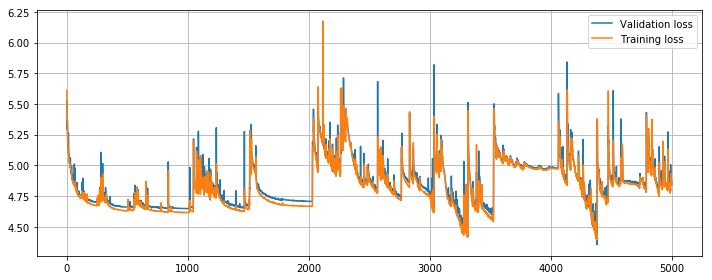

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,4))
plt.plot(autoencoder.history.history['val_loss'], label='Validation loss')
plt.plot(autoencoder.history.history['loss'], label='Training loss')
plt.legend()
plt.grid()
plt.tight_layout()

In [17]:
autoencoder.load_weights(weight_path)

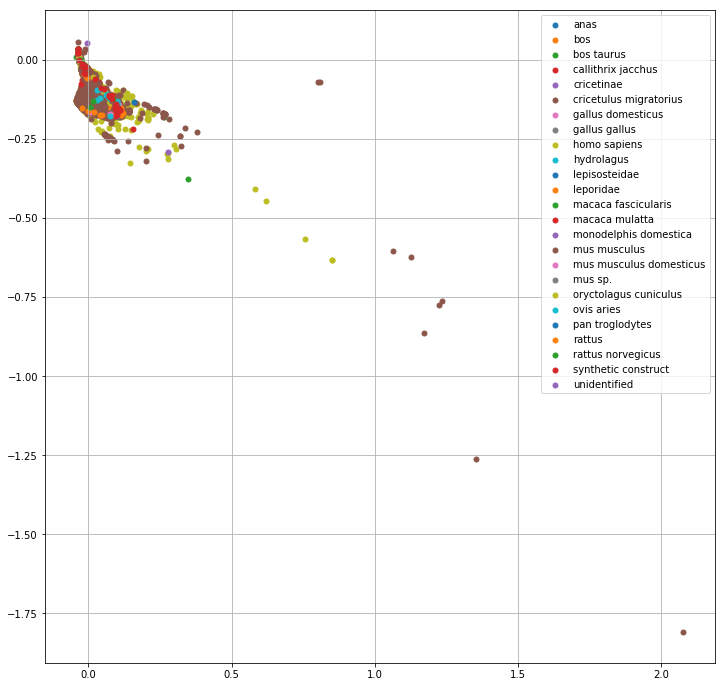

In [18]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

code = encoder.predict([VL_encoded, VH_encoded])

le = LabelEncoder().fit(animals_mask)
labels = le.transform(animals_mask)

unique_labels = np.unique(labels)
len(unique_labels)

c=sns.color_palette(n_colors=25)

f,ax = plt.subplots(figsize=(12,12))
for x in range(unique_labels.size):
    mask_labels = labels == unique_labels[x]
    ax.scatter(code[mask_labels,0], code[mask_labels,1], marker='.', c=c[x],label=le.classes_[x], s=100)
ax.legend()
leg = ax.get_legend()
for i, x in enumerate(leg.legendHandles):
    x.set_color(c[i])
ax.grid()

In [19]:
from abpytools import FabCollection, ChainCollection
import pandas as pd

combinations = pd.read_csv('/home/gil/PhD/UCB/precollection/random_pairs.txt', index_col=0, delimiter=', ')

heavy_chains = ChainCollection.load_from_json(path='/home/gil/PhD/UCB/CombinationData/AbFiles/heavy_chains.json')
light_chains = ChainCollection.load_from_json(path='/home/gil/PhD/UCB/CombinationData/AbFiles/light_chains.json')

heavy_chains_list=[]
light_chains_list=[]

for heavy, light in  combinations['Random Pairs'].str.split('-'):
    heavy_chains_list.append(heavy_chains.get_object(heavy))
    light_chains_list.append(light_chains.get_object(light))    
    
fab_collection = FabCollection(None, heavy_chains_list, light_chains_list,
                               names=['P' + str(x) for x in combinations.index.tolist()])

data = pd.read_csv('/home/gil/PhD/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

VL_data = [''.join(x).replace('-','') for x in fab_collection.numbering_table()['Light'].values]
VH_data = [''.join(x).replace('-','') for x in fab_collection.numbering_table()['Heavy'].values]

VH_data_encoded = AminoAcidEncoder(max_length=VH_LENGTH).transform(VH_data)
VL_data_encoded = AminoAcidEncoder(max_length=VL_LENGTH).transform(VL_data)

code_1 = encoder.predict([VL_data_encoded, VH_data_encoded])

latent_data = pd.DataFrame(code_1, columns=[f"Latent{x}" for x in range(1, 51)], index=fab_collection.names)

data = pd.read_csv('/home/gil/PhD/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

data.dropna(axis=0, inplace=True, subset=[data.columns[0]])

data = data.join(latent_data)

data.head()

Loading in antibody objects


/home/gil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list


,Tm D - Mean,Tm D - Std. Error,Tm2 - Mean,Tm2 - Std. Error,Latent1,Latent2,Latent3,Latent4,Latent5,Latent6,...,Latent41,Latent42,Latent43,Latent44,Latent45,Latent46,Latent47,Latent48,Latent49,Latent50
P2,64.473820,0.000000,NaN,NaN,-0.036958,0.034972,-0.100725,-0.038604,-0.050839,0.056860,...,-0.079976,-0.011134,0.062829,0.039766,0.065934,0.005641,-0.087677,-0.232456,-0.061823,0.002030
P3,73.982970,0.130358,NaN,NaN,-0.036102,0.025797,-0.093849,-0.031512,-0.051021,0.056873,...,-0.070766,-0.015038,0.055648,0.031941,0.049530,0.000879,-0.095059,-0.215754,-0.058983,0.006552
P4,64.326010,0.060344,NaN,NaN,0.053319,-0.090649,-0.072106,-0.034659,-0.077778,0.062256,...,-0.041445,0.000891,0.019565,-0.002477,-0.020454,-0.022991,-0.090388,-0.120711,-0.109693,0.008423
P6,74.192370,0.036953,NaN,NaN,0.098643,-0.165019,-0.064401,-0.022163,-0.095146,0.063259,...,0.014158,-0.000316,-0.014319,0.019736,-0.005934,-0.055245,-0.115744,-0.100963,-0.124833,0.040666
P9,72.899025,0.085337,NaN,NaN,0.113132,-0.158423,-0.078925,-0.041143,-0.092749,0.063864,...,-0.001281,-0.006561,-0.014965,0.009145,-0.006866,-0.058204,-0.107987,-0.088945,-0.137545,0.032512


In [25]:
X = data[[x for x in data.columns if 'Latent' in x]].as_matrix()

/home/gil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [26]:
norm_variance = [np.var(X[:, x] / abs(np.mean(X[:,x]))) for x in range(X.shape[1])]

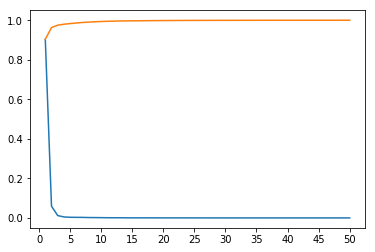

In [27]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=11))

ax.plot(range(1, 51), [norm_variance[x]/sum(norm_variance) for x in np.argsort(norm_variance)[::-1]])
ax.plot(range(1, 51), np.cumsum([norm_variance[x]/sum(norm_variance) for x in np.argsort(norm_variance)[::-1]]))

In [28]:
X=X[:, np.argsort(norm_variance)[::-1]][:, :5]

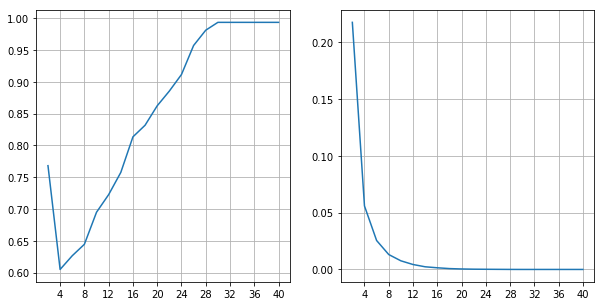

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].xaxis.set_major_locator(MaxNLocator(nbins=11))
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=11))

s_scores = []
i_scores = []
for k in range(2, 41, 2):
    kmeans = KMeans(n_clusters=k, random_state=0)
    s_scores.append(silhouette_score(X, kmeans.fit_predict(X)))
    i_scores.append(kmeans.inertia_)
ax[0].plot(range(2, 41, 2), s_scores)
ax[1].plot(range(2, 41, 2), i_scores)
ax[0].grid()
ax[1].grid()

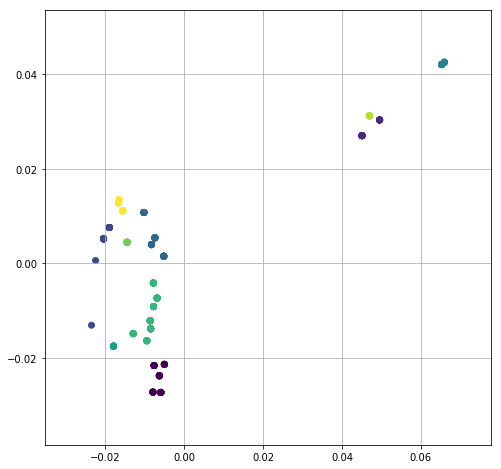

In [31]:
N_CLUSTERS = 10

kmeans = KMeans(N_CLUSTERS, random_state=0)
kmeans.fit(X)
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=kmeans.predict(X))
plt.grid()

/home/gil/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


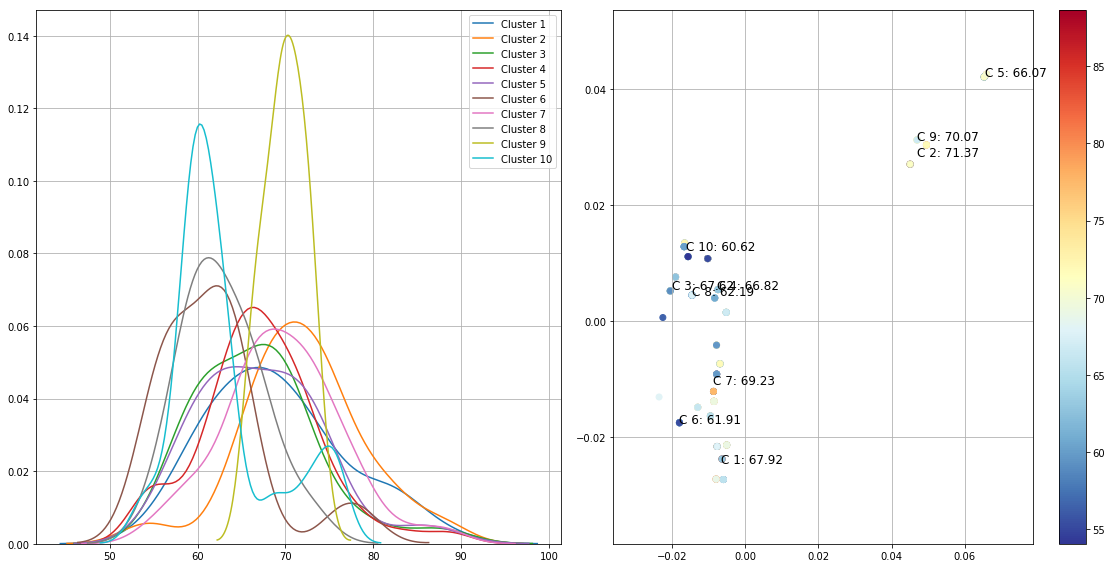

In [33]:
f, ax = plt.subplots(1,2,figsize=(16,8))
kmeans_labels = kmeans.predict(X) 
tms = ax[1].scatter(X[:,0], X[:,1], c=data['Tm D - Mean'].values, cmap='RdYlBu_r')
for x in range(N_CLUSTERS):
    ax[1].text(kmeans.cluster_centers_[x][0], kmeans.cluster_centers_[x][1],
               'C {}: {:.2f}'.format(x+1, np.median(data.values[kmeans_labels==x, 0])), fontsize=12)
cbar = f.colorbar(tms)
ax[1].grid()
for x in range(N_CLUSTERS):
    sns.distplot(data.values[kmeans_labels==x, 0], ax=ax[0], hist=False, label='Cluster {}'.format(x+1))
ax[0].legend()
ax[0].grid()
#     print(data.values[kmeans_labels==x, 0].mean(), data.values[kmeans_labels==x, 0].std())
plt.tight_layout()